# 구글 드라이브 연동

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir(r'/content/drive/MyDrive/코로나 프로젝트')

# 데이터 전처리

## 미국 확진자 데이터

1. 신규 확진자 계산 및 음수 보정
- 누적 확진자의 일별 차분(diff)을 계산하여 신규 확진자를 구함
- `back_distribute` 함수: JHU 데이터의 소급 수정으로 인한 음수 값을 처리
  - 음수가 발생하면 해당 날짜는 0으로 설정
  - 음수 크기만큼을 이전 날짜들에 거슬러 올라가며 차감
  - 이를 통해 전체 누적합의 일관성을 유지하면서 비현실적인 음수 문제를 해결

2. 인구 표준화 (Per 100k)
- 주별 인구 데이터와 병합하여 10만 명당 확진자 수로 표준화
- 캘리포니아(4천만)와 버몬트(60만)처럼 인구 규모가 크게 다른 주들을 공정하게 비교하기 위함
- 이는 WHO, CDC 등이 사용하는 국제 표준 지표


In [ ]:
import pandas as pd

#  미국 확진자 (JHU)
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
confirmed = pd.read_csv(url_confirmed)

# 날짜 컬럼 추출
date_cols = confirmed.columns[11:]

# 주(State) 단위 합계
confirmed_state = confirmed.groupby("Province_State")[date_cols].sum()

# Wide → Long 변환
confirmed_long = confirmed_state.reset_index().melt(
    id_vars="Province_State",
    value_vars=date_cols,
    var_name="date",
    value_name="confirmed"
)

# 날짜 변환
confirmed_long["date"] = pd.to_datetime(confirmed_long["date"])
confirmed_long.rename(columns={"Province_State": "state"}, inplace=True)

# 신규 확진 계산
def back_distribute(series):
    s = series.copy()
    for i in range(1, len(s)):
        if s.iloc[i] < 0:
            debt = -s.iloc[i]
            s.iloc[i] = 0
            j = i - 1
            while debt > 0 and j >= 0:
                take = min(s.iloc[j], debt)
                s.iloc[j] -= take
                debt -= take
                j -= 1
    return s

confirmed_long = confirmed_long.sort_values(["state", "date"])
confirmed_long["new_confirmed"] = (
    confirmed_long.groupby("state")["confirmed"].diff().fillna(0)
)

# 인덱스 정렬 맞추기
confirmed_long["new_confirmed"] = (
    confirmed_long.groupby("state")["new_confirmed"]
    .apply(back_distribute)
    .reset_index(level=0, drop=True)
)


# 인구 데이터 불러오기
pop_path = "/content/drive/MyDrive/코로나 프로젝트/state_population_by_year.csv"
df_pop = pd.read_csv(pop_path)

# state 이름 앞뒤 공백/특수문자 제거
df_pop["state"] = (
    df_pop["state"]
    .astype(str)
    .str.strip()
    .str.replace(r"^\.", "", regex=True)
)

# JHU 데이터에 연도 컬럼 추가
confirmed_long["year"] = confirmed_long["date"].dt.year

# Population 기준 유효한 주만 필터링
valid_states = set(df_pop["state"].unique())
confirmed_long = confirmed_long[confirmed_long["state"].isin(valid_states)]

# 인구와 병합
df = pd.merge(
    confirmed_long,
    df_pop,
    left_on=["state", "year"],
    right_on=["state", "Year"],
    how="left"
)

# 10만 명당 신규 확진율 계산
df["new_confirmed_per100k"] = (df["new_confirmed"] / df["Population"]) * 100000

# 최종 정리
df_final = df[["state", "date", "new_confirmed", "new_confirmed_per100k"]]


# CSV 저장
save_path = "/content/drive/MyDrive/코로나 프로젝트/us_covid_per100k.csv"
df_final.to_csv(save_path, index=False)

print("데이터 저장 완료:", save_path)
print(df_final.head())
print(df_final.tail(10))

# 음수 확진자 확인
neg_cases = df_final[df_final["new_confirmed"] < 0]
neg_rate  = df_final[df_final["new_confirmed_per100k"] < 0]

print("\n음수 확진자 수 ")
print(len(neg_cases))
print(neg_cases.head(10))

print("\n음수 확진율(100k당) 수 ")
print(len(neg_rate))
print(neg_rate.head(10))



데이터 저장 완료: /content/drive/MyDrive/코로나 프로젝트/us_covid_per100k.csv
     state       date  new_confirmed  new_confirmed_per100k
0  Alabama 2020-01-22            0.0                    0.0
1  Alabama 2020-01-23            0.0                    0.0
2  Alabama 2020-01-24            0.0                    0.0
3  Alabama 2020-01-25            0.0                    0.0
4  Alabama 2020-01-26            0.0                    0.0
         state       date  new_confirmed  new_confirmed_per100k
59426  Wyoming 2023-02-28          343.0              58.625764
59427  Wyoming 2023-03-01            0.0               0.000000
59428  Wyoming 2023-03-02            0.0               0.000000
59429  Wyoming 2023-03-03            0.0               0.000000
59430  Wyoming 2023-03-04            0.0               0.000000
59431  Wyoming 2023-03-05            0.0               0.000000
59432  Wyoming 2023-03-06            0.0               0.000000
59433  Wyoming 2023-03-07          226.0              38.628055


## 미국 기후 데이터

1. 주도(State Capital) 좌표 사용
- 각 주의 대표 지점으로 주도의 좌표를 사용
- 한계: 큰 주(캘리포니아, 텍사스)는 지역 내 기후 변동이 크지만, 주 전체의 평균적인 기후를 대표하는 지점으로 주도를 선택


2. 변수 선택
- T2M (Temperature at 2 meters): 지표면 2m 높이의 기온, 인간 활동 높이의 온도를 반영
- T2MDEW (Dew Point Temperature): 이슬점 온도, 상대습도 계산에 필요
- RH (Relative Humidity): Magnus 공식을 사용하여 계산
  - 공식: `RH = 100 × exp((17.625 × Td) / (243.04 + Td)) / exp((17.625 × T) / (243.04 + T))`
  - 바이러스 생존율과 비말 전파에 영향을 미치는 핵심 변수

In [ ]:
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm

# 미국 50개 주 주도 좌표 (위도, 경도)
state_capitals = {
    "Alabama": (32.377716, -86.300568),
    "Alaska": (58.301598, -134.420212),
    "Arizona": (33.448143, -112.096962),
    "Arkansas": (34.746613, -92.288986),
    "California": (38.576668, -121.493629),
    "Colorado": (39.739227, -104.984856),
    "Connecticut": (41.764046, -72.682198),
    "Delaware": (39.157307, -75.519722),
    "Florida": (30.438118, -84.281296),
    "Georgia": (33.749027, -84.388229),
    "Hawaii": (21.307442, -157.857376),
    "Idaho": (43.617775, -116.199722),
    "Illinois": (39.798363, -89.654961),
    "Indiana": (39.768623, -86.162643),
    "Iowa": (41.591087, -93.603729),
    "Kansas": (39.048191, -95.677956),
    "Kentucky": (38.186722, -84.875374),
    "Louisiana": (30.457069, -91.187393),
    "Maine": (44.307167, -69.781693),
    "Maryland": (38.978764, -76.490936),
    "Massachusetts": (42.358162, -71.063698),
    "Michigan": (42.733635, -84.555328),
    "Minnesota": (44.955097, -93.102211),
    "Mississippi": (32.303848, -90.182106),
    "Missouri": (38.579201, -92.172935),
    "Montana": (46.585709, -112.018417),
    "Nebraska": (40.808075, -96.699654),
    "Nevada": (39.163914, -119.766121),
    "New Hampshire": (43.206898, -71.537994),
    "New Jersey": (40.220596, -74.769913),
    "New Mexico": (35.68224, -105.939728),
    "New York": (42.652843, -73.757874),
    "North Carolina": (35.78043, -78.639099),
    "North Dakota": (46.82085, -100.783318),
    "Ohio": (39.961346, -82.999069),
    "Oklahoma": (35.492207, -97.503342),
    "Oregon": (44.938461, -123.030403),
    "Pennsylvania": (40.264378, -76.883598),
    "Rhode Island": (41.830914, -71.414963),
    "South Carolina": (34.000343, -81.033211),
    "South Dakota": (44.367031, -100.346405),
    "Tennessee": (36.16581, -86.784241),
    "Texas": (30.27467, -97.740349),
    "Utah": (40.777477, -111.888237),
    "Vermont": (44.262436, -72.580536),
    "Virginia": (37.538857, -77.43364),
    "Washington": (47.035805, -122.905014),
    "West Virginia": (38.336246, -81.612328),
    "Wisconsin": (43.074684, -89.384445),
    "Wyoming": (41.140259, -104.820236),
    "District of Columbia": (38.89511, -77.03637)
}

# NASA POWER API 요청 함수
def get_power_data(lat, lon, start, end):
    url = (
        f"https://power.larc.nasa.gov/api/temporal/daily/point"
        f"?parameters=T2M,T2MDEW"
        f"&community=AG"
        f"&longitude={lon}&latitude={lat}"
        f"&start={start}&end={end}"
        f"&format=JSON"
    )
    r = requests.get(url)
    r.raise_for_status()
    data = r.json()

    # JSON 구조에서 값 꺼내기
    t2m = pd.Series(data["properties"]["parameter"]["T2M"], name="temp")
    t2mdew = pd.Series(data["properties"]["parameter"]["T2MDEW"], name="dew")

    # 날짜 인덱스 맞추기
    df = pd.concat([t2m, t2mdew], axis=1)
    df.index = pd.to_datetime(df.index)

    return df
#  습도 계산 함수
def calculate_rh(df):
    T = df["temp"]
    Td = df["dew"]
    RH = 100 * (
        np.exp((17.625 * Td) / (243.04 + Td)) /
        np.exp((17.625 * T) / (243.04 + T))
    )
    df["RH"] = RH.clip(0, 100)
    return df

# 전체 주 데이터 수집
all_states = []
for state, (lat, lon) in tqdm(state_capitals.items()):
    df_state = get_power_data(lat, lon, "20200101", "20221231")  # 2020~2022년
    df_state = calculate_rh(df_state)
    df_state["state"] = state
    all_states.append(df_state)

# 병합
df_climate = pd.concat(all_states)
df_climate.reset_index(inplace=True)
df_climate.rename(columns={"index": "date"}, inplace=True)

# CSV 저장
df_climate.to_csv("us_states_climate_2020_2022.csv", index=False)
print(" 데이터 저장 완료:", df_climate.shape)
print(df_climate.head())


100%|██████████| 51/51 [01:10<00:00,  1.38s/it]


 데이터 저장 완료: (55896, 5)
        date   temp    dew         RH    state
0 2020-01-01   6.77   1.63  69.751612  Alabama
1 2020-01-02  13.17  12.12  93.351350  Alabama
2 2020-01-03  18.16  17.49  95.870240  Alabama
3 2020-01-04  10.37   6.50  76.939372  Alabama
4 2020-01-05   5.13   1.54  77.619155  Alabama


## 미국 백신 접종률 데이터

1. 백신 접종률 결측치 처리
- 백신 접종 데이터는 시작 시점이 2020년 12월(또는 그 이후)이며, 그 이전에는 당연히 데이터가 없습니다
- 처리 방법:
  - **첫 접종 이전 기간**: 0으로 채움 (아직 백신이 도입되지 않았으므로)
  - **첫 접종 이후 기간**: Forward-fill(ffill) 사용
  - 접종률은 누적 개념이므로 값이 비어있으면 이전 값을 유지

2. 4가지 접종률 변수
- `dose1_rate`: 최소 1회 접종률 - 첫 접종 효과 측정
- `fully_vaccinated_rate`: 완전 접종률 - 기본 보호 효과 측정
- `booster_shot_rate`: 부스터 접종률 - 추가 보호 효과 측정
- `omicron_bivalent_rate`: 오미크론 2가 백신 접종률 - 변이에 대한 추가 보호

In [ ]:
import pandas as pd

# 파일 경로
input_path = "/content/drive/MyDrive/코로나 프로젝트/vaccine_us_states_daily.csv"
output_path = "/content/drive/MyDrive/코로나 프로젝트/vaccine_us_states_daily_fullname.csv"

# 데이터 불러오기
df_vaccine = pd.read_csv(input_path)
df_vaccine["date"] = pd.to_datetime(df_vaccine["date"])

# 매핑 적용
state_abbrev_to_name = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", "CA": "California",
    "CO": "Colorado", "CT": "Connecticut", "DE": "Delaware", "FL": "Florida", "GA": "Georgia",
    "HI": "Hawaii", "ID": "Idaho", "IL": "Illinois", "IN": "Indiana", "IA": "Iowa",
    "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine", "MD": "Maryland",
    "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi",
    "MO": "Missouri", "MT": "Montana", "NE": "Nebraska", "NV": "Nevada", "NH": "New Hampshire",
    "NJ": "New Jersey", "NM": "New Mexico", "NY": "New York", "NC": "North Carolina",
    "ND": "North Dakota", "OH": "Ohio", "OK": "Oklahoma", "OR": "Oregon", "PA": "Pennsylvania",
    "RI": "Rhode Island", "SC": "South Carolina", "SD": "South Dakota", "TN": "Tennessee",
    "TX": "Texas", "UT": "Utah", "VT": "Vermont", "VA": "Virginia", "WA": "Washington",
    "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming",
    "DC": "District of Columbia", "AS": "American Samoa",
    "FM": "Federated States of Micronesia", "GU": "Guam", "MH": "Marshall Islands",
    "MP": "Northern Mariana Islands", "PR": "Puerto Rico", "PW": "Palau",
    "UNK": "Unknown", "VI": "U.S. Virgin Islands"
}
colname = "state" if "state" in df_vaccine.columns else "Recip_State"
df_vaccine["state"] = df_vaccine[colname].map(state_abbrev_to_name)

# 처리할 컬럼
vaccine_cols = ["dose1_rate", "fully_vaccinated_rate", "booster_shot_rate", "omicron_bivalent_rate"]

# 날짜순 정렬
df_vaccine = df_vaccine.sort_values(["state", "date"]).reset_index(drop=True)

# 주별 결측치 처리
def fill_vaccine(group):
    for col in vaccine_cols:
        first_valid = group[col].first_valid_index()
        if first_valid is None:
            # 데이터가 전혀 없는 경우 → 전부 0
            group[col] = 0
        else:
            # 첫 접종 이전 → 0
            mask_before = group.index < first_valid
            group.loc[mask_before, col] = 0

            # 첫 접종 이후 → ffill
            group[col] = group[col].ffill()

    return group

df_vaccine = df_vaccine.groupby("state", group_keys=False).apply(fill_vaccine)

# 남은 NaN은 0으로
df_vaccine[vaccine_cols] = df_vaccine[vaccine_cols].fillna(0)

# 저장
df_vaccine.to_csv(output_path, index=False)
print(f"처리 완료 → {output_path}")


처리 완료 → /content/drive/MyDrive/코로나 프로젝트/vaccine_us_states_daily_fullname.csv


## 미국 정책 데이터 (모임 제한, 접촉자 추적, 공공 행사 취소, 국제 여행 통제)


1. 결측치 Forward-Fill (ffill) 방식 사용 이유
- 정책의 특성: 한 번 발표된 정책은 새로운 발표가 있을 때까지 지속됨
- 따라서 결측값은 직전 값으로 채우는 것이 정책의 지속성을 반영함


2. 처리 단계
- 주별로 그룹화: 각 주의 정책은 독립적으로 운영
- Forward-fill 적용: 각 주 내에서 정책값을 앞으로 전파
- 시작점 처리: 팬데믹 이전에는 정책이 없으므로 0으로 설정


In [ ]:
import pandas as pd
from functools import reduce

# 저장한 파일 경로
file_path = "/content/drive/MyDrive/코로나 프로젝트/OxCGRT_timeseries_all.xlsx"

# 필요한 시트와 매핑
sheets = {
    "c4m_restrictions_on_gatherings": "restrictions_on_gatherings",
    "h3_contact_tracing": "contact_tracing",
    "c3m_cancel_public_events": "cancel_public_events",
    "c8ev_internationaltravel": "international_travel"
}

dfs = []

for sheet, col_name in sheets.items():
    df = pd.read_excel(file_path, sheet_name=sheet)

    # 미국 + 주별 단위만 (STATE_TOTAL)
    df_us_states = df[(df["country_code"] == "USA") & (df["jurisdiction"] == "STATE_TOTAL")].copy()

    if not df_us_states.empty:
        # 날짜 컬럼만 선택 (6번째 이후가 날짜임)
        date_cols = df_us_states.columns[5:]

        # long-form으로 변환
        df_melt = df_us_states.melt(
            id_vars=["region_name"],   # 주 이름 포함
            value_vars=date_cols,
            var_name="date",
            value_name=col_name
        )

        # 날짜 변환
        df_melt["date"] = pd.to_datetime(df_melt["date"], errors="coerce")

        dfs.append(df_melt)

# === 병합 ===
df_policy_us_states = reduce(
    lambda left, right: pd.merge(left, right, on=["region_name","date"], how="outer"), dfs
)

# 컬럼명 통일
df_policy_us_states = df_policy_us_states.rename(columns={"region_name":"state"})

# 정렬
df_policy_us_states = df_policy_us_states.sort_values(["state", "date"]).reset_index(drop=True)

# === 결측치 처리 ===
policy_cols = ["restrictions_on_gatherings", "contact_tracing",
               "cancel_public_events", "international_travel"]

# state별로 ffill
df_policy_us_states[policy_cols] = (
    df_policy_us_states.groupby("state")[policy_cols]
    .transform(lambda x: x.ffill())
)

# 남은 NaN → 0 처리
df_policy_us_states[policy_cols] = df_policy_us_states[policy_cols].fillna(0)

# === CSV 저장 ===
save_path = "/content/drive/MyDrive/코로나 프로젝트/policy_us_states.csv"
df_policy_us_states.to_csv(save_path, index=False)

print("미국 주별 정책 데이터 저장 완료:", save_path)
print(df_policy_us_states.head())

미국 주별 정책 데이터 저장 완료: /content/drive/MyDrive/코로나 프로젝트/policy_us_states.csv
     state       date  restrictions_on_gatherings  contact_tracing  \
0  Alabama 2020-01-01                         0.0              0.0   
1  Alabama 2020-01-02                         0.0              0.0   
2  Alabama 2020-01-03                         0.0              0.0   
3  Alabama 2020-01-04                         0.0              0.0   
4  Alabama 2020-01-05                         0.0              0.0   

   cancel_public_events  international_travel  
0                   0.0                   0.0  
1                   0.0                   0.0  
2                   0.0                   0.0  
3                   0.0                   0.0  
4                   0.0                   0.0  


## 미국 주별 모빌리티 데이터


1. 표준화:
- 기준선(Baseline) 대비 % 변화로 표준화되어 있음



2. 기준선 (Baseline)
- 기준: 2020년 1월 3일 ~ 2월 6일 (5주간)의 평균값
- 예: +20% = 기준보다 20% 더 많은 이동, -50% = 기준보다 50% 적은 이동

3. 결측치 처리

- Forward-fill
  - 미래 정보 누출(Data Leakage) 방지를 위해 우선 과거 값으로 채움
  - 한계: 갑작스런 변화는 반영하지 못함

- 2단계: 선형 보간 (최대 3일)
    - 짧은 공백(1-3일)은 선형 변화로 추정 가능
    - 예: 월요일 -20%, 목요일 -10% → 화수요일은 -17%, -13%로 보간
    - 3일 제한: 너무 긴 보간은 부정확할 수 있음

- 3단계: 7일 이동평균
  - 여전히 남은 긴 결측치는 과거 7일 평균으로 대체
    - 이동 패턴은 주간 사이클을 보임 (평일 vs 주말)
    - 7일 평균은 이러한 주기성을 반영함
    - 극단값의 영향을 완화함





In [ ]:
import pandas as pd
import glob

#  파일 경로 (연도별 3개)
file_paths = [
    "/content/drive/MyDrive/코로나 프로젝트/2020_US_Region_Mobility_Report.csv",
    "/content/drive/MyDrive/코로나 프로젝트/2021_US_Region_Mobility_Report.csv",
    "/content/drive/MyDrive/코로나 프로젝트/2022_US_Region_Mobility_Report.csv"
]

dfs = []

for path in file_paths:
    df = pd.read_csv(path)

    # 미국 주(State)만 추출 (County 단위 제거)
    df_us_states = df[
        (df["country_region_code"] == "US") &
        (df["sub_region_1"].notna()) &
        (df["sub_region_2"].isna())
    ].copy()

    # 필요한 컬럼만 선택
    df_us_states = df_us_states[[
        "sub_region_1", "date",
        "retail_and_recreation_percent_change_from_baseline",
        "grocery_and_pharmacy_percent_change_from_baseline",
        "parks_percent_change_from_baseline",
        "transit_stations_percent_change_from_baseline",
        "workplaces_percent_change_from_baseline",
        "residential_percent_change_from_baseline"
    ]]

    # 컬럼명 정리
    df_us_states = df_us_states.rename(columns={
        "sub_region_1": "state"
    })

    # 날짜 변환
    df_us_states["date"] = pd.to_datetime(df_us_states["date"])

    dfs.append(df_us_states)

#  연도별 데이터 합치기
df_mobility_all = pd.concat(dfs, ignore_index=True)

# 정렬
df_mobility_all = df_mobility_all.sort_values(["state", "date"]).reset_index(drop=True)

#  결측치 처리 (ffill + 최대 3일 선형보간, 그 외 7일 이동평균)
mobility_cols = [
    "retail_and_recreation_percent_change_from_baseline",
    "grocery_and_pharmacy_percent_change_from_baseline",
    "parks_percent_change_from_baseline",
    "transit_stations_percent_change_from_baseline",
    "workplaces_percent_change_from_baseline",
    "residential_percent_change_from_baseline"
]

def fill_mobility(group):
    # 과거 방향으로만 ffill
    group[mobility_cols] = group[mobility_cols].ffill()

    # 최대 3일 연속 결측만 선형보간 허용
    group[mobility_cols] = group[mobility_cols].interpolate(
        method="linear", limit=3, limit_direction="forward"
    )

    # 여전히 남은 긴 결측은 과거 7일 평균으로 대체
    for col in mobility_cols:
        group[col] = group[col].fillna(group[col].rolling(7, min_periods=1).mean())

    return group

df_mobility_all = df_mobility_all.groupby("state", group_keys=False).apply(fill_mobility)

# CSV 저장
save_path = "/content/drive/MyDrive/코로나 프로젝트/mobility_us_states_2020_2022.csv"
df_mobility_all.to_csv(save_path, index=False)

print("미국 주별 모빌리티 데이터(2020~2022) 저장 완료:", save_path)
print(df_mobility_all.head())


미국 주별 모빌리티 데이터(2020~2022) 저장 완료: /content/drive/MyDrive/코로나 프로젝트/mobility_us_states_2020_2022.csv
     state       date  retail_and_recreation_percent_change_from_baseline  \
0  Alabama 2020-02-15                                                5.0    
1  Alabama 2020-02-16                                                0.0    
2  Alabama 2020-02-17                                                3.0    
3  Alabama 2020-02-18                                               -4.0    
4  Alabama 2020-02-19                                                4.0    

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                                2.0   
1                                               -2.0   
2                                                0.0   
3                                               -3.0   
4                                                1.0   

   parks_percent_change_from_baseline  \
0                                39.0   
1                   

# 변수 데이터 생성

In [ ]:
import pandas as pd

# 파일 경로
path_mobility = "/content/drive/MyDrive/코로나 프로젝트/mobility_us_states_2020_2022.csv"
path_policy   = "/content/drive/MyDrive/코로나 프로젝트/policy_us_states.csv"
path_climate  = "/content/drive/MyDrive/코로나 프로젝트/us_states_climate_2020_2022.csv"
path_vaccine  = "/content/drive/MyDrive/코로나 프로젝트/vaccine_us_states_daily_fullname.csv"
path_covid    = "/content/drive/MyDrive/코로나 프로젝트/us_covid_per100k.csv"

# 데이터 불러오기
df_mobility = pd.read_csv(path_mobility, parse_dates=["date"])
df_policy   = pd.read_csv(path_policy, parse_dates=["date"])
df_climate  = pd.read_csv(path_climate, parse_dates=["date"])
df_vaccine  = pd.read_csv(path_vaccine, parse_dates=["date"])
df_covid    = pd.read_csv(path_covid, parse_dates=["date"])

# 컬럼명 정리
if "region_name" in df_policy.columns:
    df_policy.rename(columns={"region_name": "state"}, inplace=True)

if "Recip_State" in df_vaccine.columns:
    df_vaccine.rename(columns={"Recip_State": "state"}, inplace=True)

if "Province_State" in df_covid.columns:
    df_covid.rename(columns={"Province_State": "state"}, inplace=True)

# state 클린업
valid_states = {
    "Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut","Delaware",
    "Florida","Georgia","Hawaii","Idaho","Illinois","Indiana","Iowa","Kansas","Kentucky",
    "Louisiana","Maine","Maryland","Massachusetts","Michigan","Minnesota","Mississippi","Missouri",
    "Montana","Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
    "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania","Rhode Island",
    "South Carolina","South Dakota","Tennessee","Texas","Utah","Vermont","Virginia",
    "Washington","West Virginia","Wisconsin","Wyoming","District of Columbia"
}

state_mapping = {
    "Washington DC": "District of Columbia",
    "DC": "District of Columbia",
    "D.C.": "District of Columbia"
}

def clean_states(df, state_col="state"):
    df[state_col] = df[state_col].replace(state_mapping)
    return df[df[state_col].isin(valid_states)].copy()

df_mobility = clean_states(df_mobility)
df_policy   = clean_states(df_policy)
df_climate  = clean_states(df_climate)
df_vaccine  = clean_states(df_vaccine)
df_covid    = clean_states(df_covid)

# 불필요한 컬럼 제거
drop_cols = ["Unnamed: 0", "index"]
for d in [df_mobility, df_policy, df_climate, df_vaccine, df_covid]:
    for c in drop_cols:
        if c in d.columns:
            d.drop(columns=[c], inplace=True)

# 병합 (features + covid)
df_features = df_mobility.merge(df_policy,  on=["state", "date"], how="left")
df_features = df_features.merge(df_climate, on=["state", "date"], how="left")
df_features = df_features.merge(df_vaccine, on=["state", "date"], how="left")
df_features = df_features.merge(df_covid,   on=["state", "date"], how="left")  # ★ covid 추가 병합

#  날짜 필터링
df_features = df_features[
    (df_features["date"] >= "2020-01-01") &
    (df_features["date"] <= "2022-03-01")
].copy()

#  백신 결측치 처리
vaccine_cols = ["dose1_rate", "fully_vaccinated_rate", "booster_shot_rate", "omicron_bivalent_rate"]
df_features[vaccine_cols] = df_features[vaccine_cols].fillna(0)

#  최종 확인
print("최종 기간:", df_features["date"].min(), "→", df_features["date"].max())
print("최종 데이터셋 shape:", df_features.shape)
print("state 고유값 개수:", df_features['state'].nunique())
print("state 리스트:", sorted(df_features['state'].unique())[:10], "...")
print("\n컬럼 목록:", df_features.columns.tolist()[:15], "...")
df_features.head()

최종 기간: 2020-02-15 00:00:00 → 2022-03-01 00:00:00
최종 데이터셋 shape: (38046, 21)
state 고유값 개수: 51
state 리스트: ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida'] ...

컬럼 목록: ['state', 'date', 'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline', 'restrictions_on_gatherings', 'contact_tracing', 'cancel_public_events', 'international_travel', 'temp', 'dew', 'RH'] ...


,state,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,restrictions_on_gatherings,contact_tracing,...,international_travel,temp,dew,RH,dose1_rate,fully_vaccinated_rate,booster_shot_rate,omicron_bivalent_rate,new_confirmed,new_confirmed_per100k
0,Alabama,2020-02-15,5.0,2.0,39.0,7.0,2.0,-1.0,0.0,1.0,...,3.0,6.15,1.63,72.791864,0.0,0.0,0.0,0.0,0.0,0.0
1,Alabama,2020-02-16,0.0,-2.0,-7.0,3.0,-1.0,1.0,0.0,1.0,...,3.0,9.72,8.55,92.421388,0.0,0.0,0.0,0.0,0.0,0.0
2,Alabama,2020-02-17,3.0,0.0,17.0,7.0,-17.0,4.0,0.0,1.0,...,3.0,12.19,11.03,92.623561,0.0,0.0,0.0,0.0,0.0,0.0
3,Alabama,2020-02-18,-4.0,-3.0,-11.0,-1.0,1.0,2.0,0.0,1.0,...,3.0,16.75,16.15,96.254969,0.0,0.0,0.0,0.0,0.0,0.0
4,Alabama,2020-02-19,4.0,1.0,6.0,4.0,1.0,0.0,0.0,1.0,...,3.0,13.93,12.08,88.614097,0.0,0.0,0.0,0.0,0.0,0.0


## 시차 변수 추가

1. 시차 변수 생성 목적
- 자기상관(Autocorrelation): 오늘의 확진자 수는 어제, 지난주와 강하게 연관됨
- 잠복기 효과: COVID-19 감염부터 확진까지 평균 5-6일, 최대 14일 소요
- 정책 효과 지연: 정책이 시행되어도 효과는 1-2주 후에 나타남
- 기후 효과 지연: 기후가 바이러스 생존이나 면역에 미치는 영향도 시차가 있음

In [ ]:
import pandas as pd

target_col = "new_confirmed_per100k"

# 1. 타깃 Lag
for lag in [1, 7, 14]:
    df_features[f"{target_col}_lag{lag}"] = (
        df_features.groupby("state")[target_col].shift(lag)
    )

# 2. 타깃 Rolling Mean
for window in [7, 14]:
    df_features[f"{target_col}_rollmean{window}"] = (
        df_features.groupby("state")[target_col]
        .transform(lambda x: x.shift(1).rolling(window).mean())
    )

# 3. 주요 피처 Lag
feature_lag_vars = [
    # mobility
    "retail_and_recreation_percent_change_from_baseline",
    "workplaces_percent_change_from_baseline",
    "residential_percent_change_from_baseline",
    # policy
    "restrictions_on_gatherings",
    "contact_tracing",
    # climate
    "temp", "RH",
    # vaccine
    "dose1_rate", "fully_vaccinated_rate"
]

for var in feature_lag_vars:
    for lag in [7, 14]:
        df_features[f"{var}_lag{lag}"] = df_features.groupby("state")[var].shift(lag)

# 4. 날짜 필터링
df_features = df_features[
    (df_features["date"] >= "2020-03-01") &
    (df_features["date"] <= "2022-03-01")
].copy()


# 6. 결측치 제거
df_features = df_features.dropna().reset_index(drop=True)

print("최종 shape:", df_features.shape)
print("기간:", df_features['date'].min(), "→", df_features['date'].max())
print("lag/rollmean 예시:", [c for c in df_features.columns if "lag" in c or "rollmean" in c][:10])


최종 shape: (37281, 44)
기간: 2020-03-01 00:00:00 → 2022-03-01 00:00:00
lag/rollmean 예시: ['new_confirmed_per100k_lag1', 'new_confirmed_per100k_lag7', 'new_confirmed_per100k_lag14', 'new_confirmed_per100k_rollmean7', 'new_confirmed_per100k_rollmean14', 'retail_and_recreation_percent_change_from_baseline_lag7', 'retail_and_recreation_percent_change_from_baseline_lag14', 'workplaces_percent_change_from_baseline_lag7', 'workplaces_percent_change_from_baseline_lag14', 'residential_percent_change_from_baseline_lag7']


## 타겟 변수 삭제

In [ ]:
import pandas as pd

# 타깃 컬럼 정의
target_raw_cols = ["new_confirmed", "new_confirmed_per100k"]

# df_lagged에서 타깃 변수 제거
df_features = df_features.drop(columns=target_raw_cols, errors="ignore").copy()

print("최종 shape:", df_features.shape)
print("컬럼 수:", len(df_features.columns))
print("컬럼 예시:", df_features.columns[:15].tolist())


최종 shape: (37281, 42)
컬럼 수: 42
컬럼 예시: ['state', 'date', 'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline', 'restrictions_on_gatherings', 'contact_tracing', 'cancel_public_events', 'international_travel', 'temp', 'dew', 'RH']


## 시간 변수 추가

1. 시간 변수 추가 목적
- 팬데믹은 시간에 따라 변화하는 현상
- 시간 요인을 통제하지 않으면 다른 변수의 효과를 정확히 측정할 수 없음
- 예: 여름에 확진자가 감소했다면, 온도 효과인가? 계절적 행동 변화인가?

2. 각 시간 변수의 의미

- day_of_week (요일)
  - 주간 사이클 포착
  - 주말과 평일의 이동 패턴이 다름

- month (월)
  - 계절성 포착
  - 계절적 행동 변화 (여름 휴가, 겨울 실내 활동)


- days_from_start (팬데믹 경과일)
  - 기준점: 2020년 3월 1일 (미국 팬데믹 본격 시작)
  - 팬데믹의 전체적인 시간 경과를 나타냄


- is_holiday (공휴일 여부)
  - 값: 0=평일, 1=연방공휴일
  - 대상: 미국 연방 공휴일 (New Year's Day, Independence Day, Thanksgiving 등)
  - 공휴일에는 가족 모임, 여행이 증가


In [ ]:
import pandas as pd
import holidays

# 날짜 컬럼 datetime 변환
df_features["date"] = pd.to_datetime(df_features["date"])

# 요일
df_features["day_of_week"] = df_features["date"].dt.dayofweek

# 월
df_features["month"] = df_features["date"].dt.month

# 팬데믹 시작일 기준 경과일
pandemic_start = pd.to_datetime("2020-03-01")
df_features["days_from_start"] = (df_features["date"] - pandemic_start).dt.days

# 연방 공휴일 여부 (2020~2022)
us_federal_holidays = holidays.US(years=[2020,2021,2022])
df_features["is_holiday"] = df_features["date"].isin(us_federal_holidays).astype(int)

print(df_features.head(15))


      state       date  retail_and_recreation_percent_change_from_baseline  \
0   Alabama 2020-03-01                                               16.0    
1   Alabama 2020-03-02                                                8.0    
2   Alabama 2020-03-03                                               20.0    
3   Alabama 2020-03-04                                                7.0    
4   Alabama 2020-03-05                                                7.0    
5   Alabama 2020-03-06                                                9.0    
6   Alabama 2020-03-07                                               12.0    
7   Alabama 2020-03-08                                               12.0    
8   Alabama 2020-03-09                                               10.0    
9   Alabama 2020-03-10                                                9.0    
10  Alabama 2020-03-11                                               10.0    
11  Alabama 2020-03-12                                          

/tmp/ipython-input-3723779621.py:19: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_features["is_holiday"] = df_features["date"].isin(us_federal_holidays).astype(int)


## 변이 바이러스 더미 변수 추가

In [ ]:
import pandas as pd

df_features['date'] = pd.to_datetime(df_features['date'])

# 델타 변이 더미 변수 생성
df_features['variant_delta'] = (df_features['date'] >= '2021-07-01').astype(int)

# 오미크론 변이 더미 변수 생성
df_features['variant_omicron'] = (df_features['date'] >= '2021-11-26').astype(int)


# 결과 확인
print("변이 바이러스 더미 변수 추가 완료")
print(df_features.head())

# 저장

features_path = "/content/drive/MyDrive/코로나 프로젝트/df_features.csv"
df_features.to_csv(features_path, index=False)
df_features = pd.read_csv(features_path)

변이 바이러스 더미 변수 추가 완료
     state       date  retail_and_recreation_percent_change_from_baseline  \
0  Alabama 2020-03-01                                               16.0    
1  Alabama 2020-03-02                                                8.0    
2  Alabama 2020-03-03                                               20.0    
3  Alabama 2020-03-04                                                7.0    
4  Alabama 2020-03-05                                                7.0    

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                               10.0   
1                                                4.0   
2                                               15.0   
3                                                0.0   
4                                                6.0   

   parks_percent_change_from_baseline  \
0                                53.0   
1                                -2.0   
2                                33.0   
3               

In [ ]:
df_features.isnull().sum()

,0
state,0
date,0
retail_and_recreation_percent_change_from_baseline,0
grocery_and_pharmacy_percent_change_from_baseline,0
parks_percent_change_from_baseline,0
transit_stations_percent_change_from_baseline,0
workplaces_percent_change_from_baseline,0
residential_percent_change_from_baseline,0
restrictions_on_gatherings,0
contact_tracing,0


## State 원 핫 인코딩











원 핫 인코딩의 필요성

1. 범주형 변수의 수치 변환
- `state` 변수는 문자열 (Alabama, Alaska, ..., Wyoming)
- 대부분의 머신러닝 알고리즘은 숫자만 처리 가능
- 따라서 51개 주를 수치형으로 변환

2. 왜 단순 숫자 할당은 안 되는가?
- 잘못된 방법: Alabama=1, Alaska=2, Arizona=3, ...
- 문제점: 모델이 "Alaska(2)가 Alabama(1)보다 2배 크다"는 의미 없는 관계를 학습
- 순서 관계: 주(State) 간에는 대소 관계나 순서가 없음

In [ ]:
import pandas as pd

# 원본 데이터 복사
df_ml = df_features.copy()

# 주(state) 인코딩
state_dummies = pd.get_dummies(df_ml["state"], prefix="state")
df_ml = pd.concat([df_ml, state_dummies], axis=1)

# CSV로 저장
ml_csv_path = "/content/drive/MyDrive/코로나 프로젝트/df_ml.csv"
df_ml.to_csv(ml_csv_path, index=False)

print("CSV 저장 완료:", ml_csv_path)

# 이후 불러올 때
df_ml = pd.read_csv(ml_csv_path)
print("불러온 데이터 shape:", df_ml.shape)

# 학습 시점에서만 drop
X = df_ml.drop(columns=["state", "date"])  # 모델에 투입할 feature


CSV 저장 완료: /content/drive/MyDrive/코로나 프로젝트/df_ml.csv
불러온 데이터 shape: (37281, 99)


# 타깃 데이터 생성





타겟 변수:
```python
target_7d = x.shift(-1).rolling(7, min_periods=7).mean()
```
- **t 시점의 target = (t+1)~(t+7)일의 평균 확진율**
- 예: 3월 1일 target = 3월 2일~8일의 7일 평균

타겟 설정 이유

**1. 미래 예측 목표**
- "오늘 데이터로 다음 주 평균 확진율 예측"
- 보건 당국의 실제 니즈 (병상 준비, 정책 결정)

**2. 정보 누설 방지**
-  `rolling(7)` (과거 평균): feature와 target 겹침 → 정보 누설
-  `shift(-1).rolling(7)` (미래 평균): feature와 독립 → 실제 예측 가능

**3. Smoothing 효과**
- 7일 평균으로 노이즈 감소 (주말 효과, 보고 지연 제거)

**4. `min_periods=7`**
- 7개 미만 데이터는 NaN 처리 → 불완전 데이터 제거





In [ ]:
import pandas as pd

#  파일 경로
path_covid = "/content/drive/MyDrive/코로나 프로젝트/us_covid_per100k.csv"
output_path = "/content/drive/MyDrive/코로나 프로젝트/df_targets.csv"

#  원본 불러오기
df_covid = pd.read_csv(path_covid, parse_dates=["date"])

#  이동평균 타깃 생성
df_covid["target_7d"] = (
    df_covid.groupby("state")["new_confirmed_per100k"]
    .transform(lambda x: x.shift(-1).rolling(7, min_periods=7).mean())
)

#  NaN 제거 (초반 구간 drop)
df_covid = df_covid.dropna(subset=["target_7d"])

#  날짜 필터링 (2020-03-01 이후만 남기기)
df_covid = df_covid[df_covid["date"] >= "2020-03-01"].copy()

#  저장
df_covid.to_csv(output_path, index=False)
df_targets = pd.read_csv(output_path, parse_dates=["date"])

print("이동평균 추가 완료 & CSV 저장:", output_path)
print("최종 기간:", df_covid["date"].min(), "→", df_covid["date"].max())
print("shape:", df_targets.shape)
print(df_targets.head(15))


이동평균 추가 완료 & CSV 저장: /content/drive/MyDrive/코로나 프로젝트/df_targets.csv
최종 기간: 2020-03-01 00:00:00 → 2023-03-08 00:00:00
shape: (57356, 5)
      state       date  new_confirmed  new_confirmed_per100k  target_7d
0   Alabama 2020-03-01            0.0               0.000000   0.000000
1   Alabama 2020-03-02            0.0               0.000000   0.000000
2   Alabama 2020-03-03            0.0               0.000000   0.000000
3   Alabama 2020-03-04            0.0               0.000000   0.000000
4   Alabama 2020-03-05            0.0               0.000000   0.000000
5   Alabama 2020-03-06            0.0               0.000000   0.000000
6   Alabama 2020-03-07            0.0               0.000000   0.000000
7   Alabama 2020-03-08            0.0               0.000000   0.000000
8   Alabama 2020-03-09            0.0               0.000000   0.000000
9   Alabama 2020-03-10            0.0               0.000000   0.008515
10  Alabama 2020-03-11            3.0               0.059605   0.011353
1

# 데이터 불러오기

In [3]:
import pandas as pd
ml_csv_path = "/content/drive/MyDrive/코로나 프로젝트/df_ml.csv"
df_ml = pd.read_csv(ml_csv_path)

features_path = "/content/drive/MyDrive/코로나 프로젝트/df_features.csv"
df_features = pd.read_csv(features_path)

output_path = "/content/drive/MyDrive/코로나 프로젝트/df_targets.csv"
df_targets = pd.read_csv(output_path)

# Exploratory Data Analysis (EDA)



## EDA용 데이터 프레임 생성

In [15]:
import pandas as pd

# date 컬럼 형식 통일
df_features["date"] = pd.to_datetime(df_features["date"])
df_targets["date"]  = pd.to_datetime(df_targets["date"])

# EDA 용 병합
df_eda = pd.merge(
    df_features,
    df_targets,
    on=["state", "date"],
    how="inner"
)

# 저장 & 불러오기
eda_path = "/content/drive/MyDrive/코로나 프로젝트/df_eda.csv"
df_eda.to_csv(eda_path, index=False)
df_eda = pd.read_csv(eda_path, parse_dates=["date"])  # 불러올 때도 date를 datetime으로

print("EDA 데이터셋 shape:", df_eda.shape)


EDA 데이터셋 shape: (37281, 51)


## 기본 데이터 정보

In [16]:
print("== 데이터 기본 정보")
print(f"데이터 크기: {df_eda.shape}")
print(f"기간: {df_eda['date'].min()} ~ {df_eda['date'].max()}")
print(f"주 개수: {df_eda['state'].nunique()}개")
print(f"총 관측치: {len(df_eda):,}개")

print("\n== 컬럼 정보")
print(df_eda.info())

print("\n== 기본 통계량")
print(df_eda.describe())

== 데이터 기본 정보
데이터 크기: (37281, 51)
기간: 2020-03-01 00:00:00 ~ 2022-03-01 00:00:00
주 개수: 51개
총 관측치: 37,281개

== 컬럼 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37281 entries, 0 to 37280
Data columns (total 51 columns):
 #   Column                                                    Non-Null Count  Dtype         
---  ------                                                    --------------  -----         
 0   state                                                     37281 non-null  object        
 1   date                                                      37281 non-null  datetime64[ns]
 2   retail_and_recreation_percent_change_from_baseline        37281 non-null  float64       
 3   grocery_and_pharmacy_percent_change_from_baseline         37281 non-null  float64       
 4   parks_percent_change_from_baseline                        37281 non-null  float64       
 5   transit_stations_percent_change_from_baseline             37281 non-null  float64       
 6   workplaces_percent_c

## 결측치 분석

In [17]:
print("== 결측치 분석")
missing_data = df_eda.isnull().sum()
missing_percent = (missing_data / len(df_eda)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0])

# 주별 결측치 패턴 확인
print("\n== 주별 결측치 패턴")
missing_by_state = df_eda.groupby('state').apply(lambda x: x.isnull().sum())
print("주별 결측치가 있는 컬럼:")
for col in missing_by_state.columns:
    if missing_by_state[col].sum() > 0:
        print(f"\n{col}:")
        print(missing_by_state[missing_by_state[col] > 0][col])


== 결측치 분석
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []

== 주별 결측치 패턴
주별 결측치가 있는 컬럼:


/tmp/ipython-input-2740232086.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_state = df_eda.groupby('state').apply(lambda x: x.isnull().sum())


## 주요 변수 분포 시각화



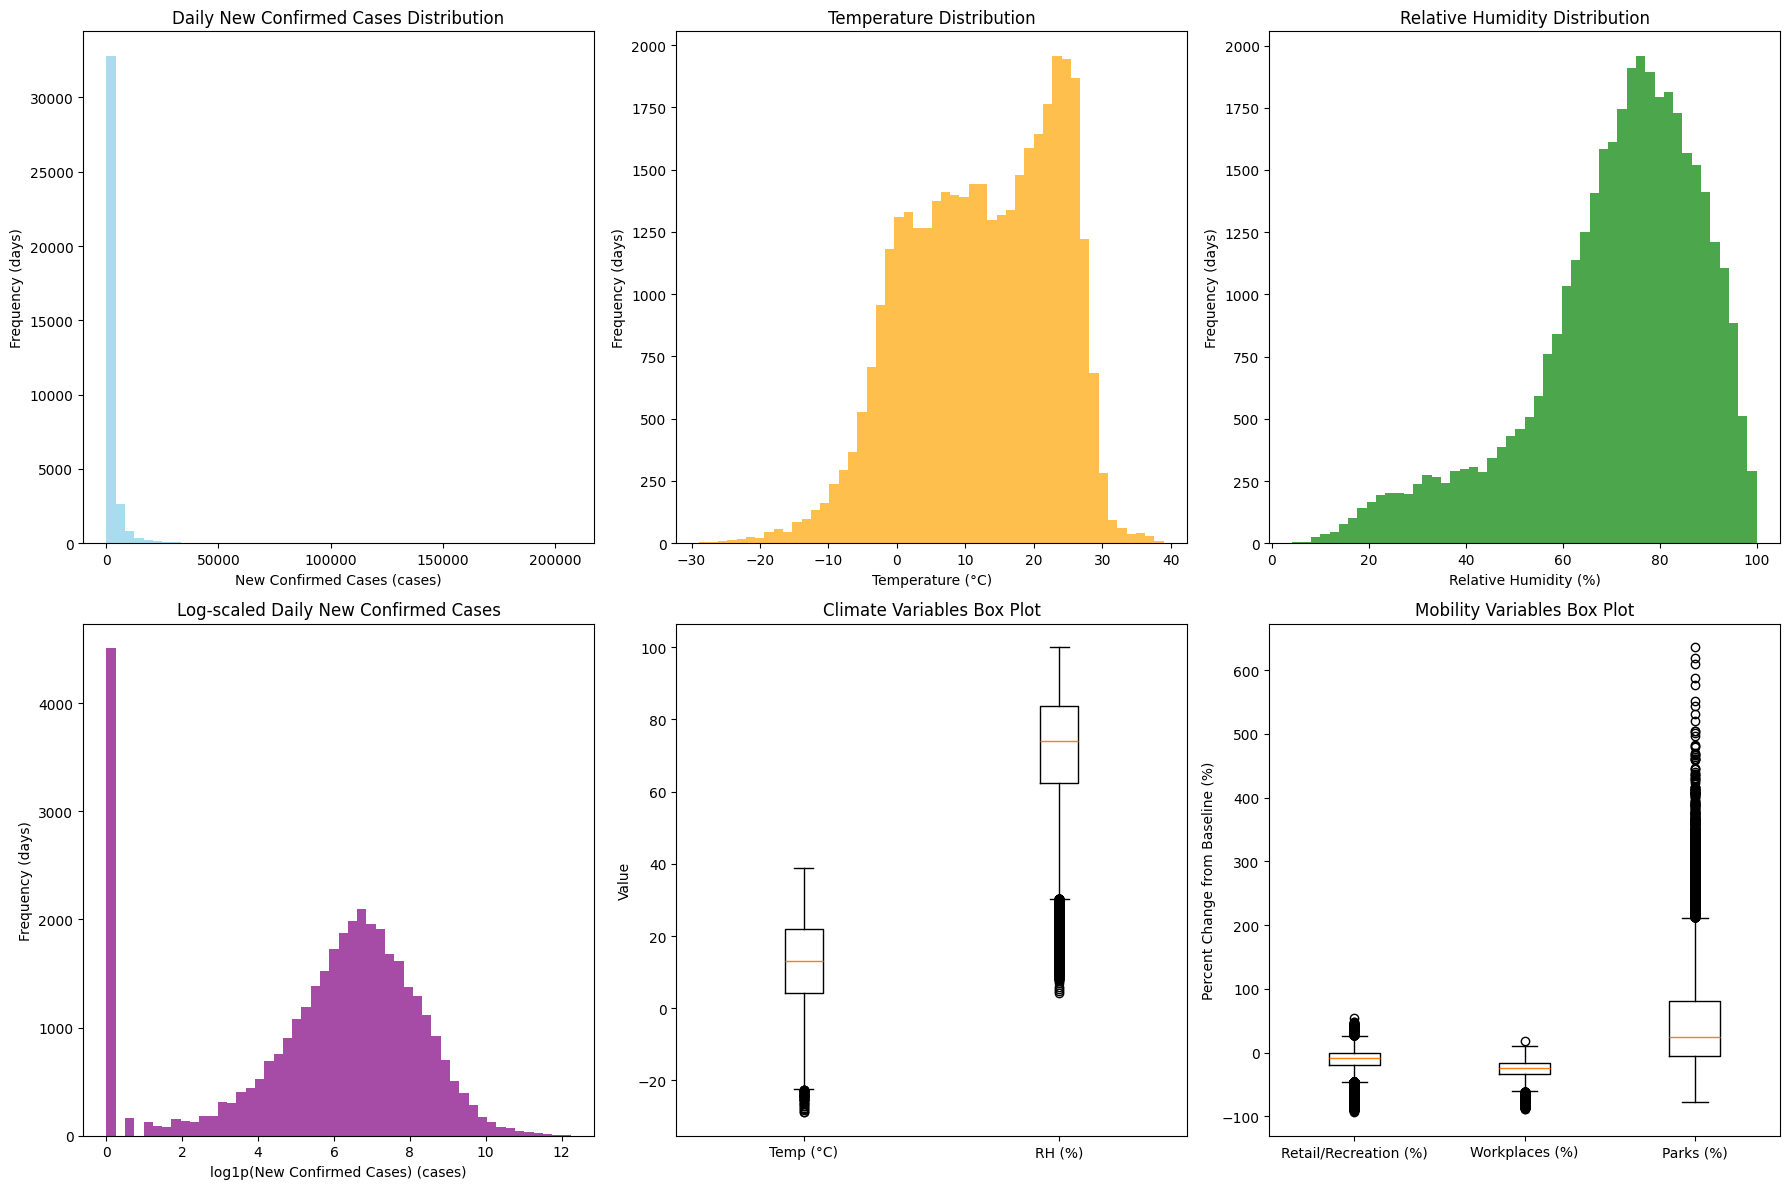

== 이상치 정보 (IQR 기준, 음수 제외) 
[new_confirmed]
 - 이상치 개수: 4218 (11.31%)
 - 값 범위: 0.00 ~ 207110.00
 - IQR 하한: -2464.50, 상한: 4395.50
--------------------------------------------------
[new_confirmed_per100k]
 - 이상치 개수: 3169 (8.50%)
 - 값 범위: 0.00 ~ 1475.95
 - IQR 하한: -44.75, 상한: 85.27
--------------------------------------------------
[temp]
 - 이상치 개수: 43 (0.12%)
 - 값 범위: -28.85 ~ 38.97
 - IQR 하한: -22.50, 상한: 48.50
--------------------------------------------------
[RH]
 - 이상치 개수: 1559 (4.18%)
 - 값 범위: 4.27 ~ 100.00
 - IQR 하한: 30.36, 상한: 115.80
--------------------------------------------------


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#  로그 변환용 안전 처리
def safe_log_transform(series):
    """
    음수 -> 0, NaN -> 0 처리 후 log1p 변환
    """
    return np.log1p(series.clip(lower=0).fillna(0))

#  분포 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 확진자 수 분포 (원본)
axes[0, 0].hist(df_eda['new_confirmed'].clip(lower=0).fillna(0), bins=50, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Daily New Confirmed Cases Distribution')
axes[0, 0].set_xlabel('New Confirmed Cases (cases)')
axes[0, 0].set_ylabel('Frequency (days)')

# 확진자 수 분포 (로그 변환)
log_confirmed = safe_log_transform(df_eda['new_confirmed'])
axes[1, 0].hist(log_confirmed, bins=50, alpha=0.7, color='purple')
axes[1, 0].set_title('Log-scaled Daily New Confirmed Cases')
axes[1, 0].set_xlabel('log1p(New Confirmed Cases) (cases)')
axes[1, 0].set_ylabel('Frequency (days)')

# 기온 분포
axes[0, 1].hist(df_eda['temp'].dropna(), bins=50, alpha=0.7, color='orange')
axes[0, 1].set_title('Temperature Distribution')
axes[0, 1].set_xlabel('Temperature (°C)')
axes[0, 1].set_ylabel('Frequency (days)')

# 습도 분포
axes[0, 2].hist(df_eda['RH'].dropna(), bins=50, alpha=0.7, color='green')
axes[0, 2].set_title('Relative Humidity Distribution')
axes[0, 2].set_xlabel('Relative Humidity (%)')
axes[0, 2].set_ylabel('Frequency (days)')

# 기후 변수 박스플롯 (온도, 습도 같이)
axes[1, 1].boxplot([df_eda['temp'].dropna(), df_eda['RH'].dropna()],
                   tick_labels=['Temp (°C)', 'RH (%)'])
axes[1, 1].set_title('Climate Variables Box Plot')
axes[1, 1].set_ylabel('Value')

# Mobility 변수 중 일부 박스플롯
mobility_cols = [
    'retail_and_recreation_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'parks_percent_change_from_baseline'
]
axes[1, 2].boxplot([df_eda[c].dropna() for c in mobility_cols],
                   tick_labels=['Retail/Recreation (%)', 'Workplaces (%)', 'Parks (%)'])
axes[1, 2].set_title('Mobility Variables Box Plot')
axes[1, 2].set_ylabel('Percent Change from Baseline (%)')

plt.tight_layout()
plt.show()

#  이상치 확인 (IQR 기준, 음수 제외)
print("== 이상치 정보 (IQR 기준, 음수 제외) ")
numeric_cols = ['new_confirmed', 'new_confirmed_per100k', 'temp', 'RH']
for col in numeric_cols:
    # 음수는 제외하고 이상치 탐색
    series = df_eda[col].dropna()
    if col in ['new_confirmed', 'new_confirmed_per100k']:
        series = series[series >= 0]

    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    ratio = len(outliers) / len(series) * 100

    print(f"[{col}]")
    print(f" - 이상치 개수: {len(outliers)} ({ratio:.2f}%)")
    print(f" - 값 범위: {series.min():.2f} ~ {series.max():.2f}")
    print(f" - IQR 하한: {lower_bound:.2f}, 상한: {upper_bound:.2f}")
    print("-"*50)


## 상관관계 분석

1. 상관관계 분석 목적
- 변수 간 선형 관계의 강도와 방향 파악
- 다중공선성(Multicollinearity) 문제 사전 감지

2. 상관계수 해석 기준
- |r| > 0.7: 강한 상관관계
- 0.4 < |r| < 0.7: 중간 상관관계
- |r| < 0.4: 약한 상관관계

3. 히트맵 색상 의미
- 빨간색: 양의 상관관계 (한 변수 증가 → 다른 변수 증가)
- 파란색: 음의 상관관계 (한 변수 증가 → 다른 변수 감소)
- 흰색: 상관관계 없음


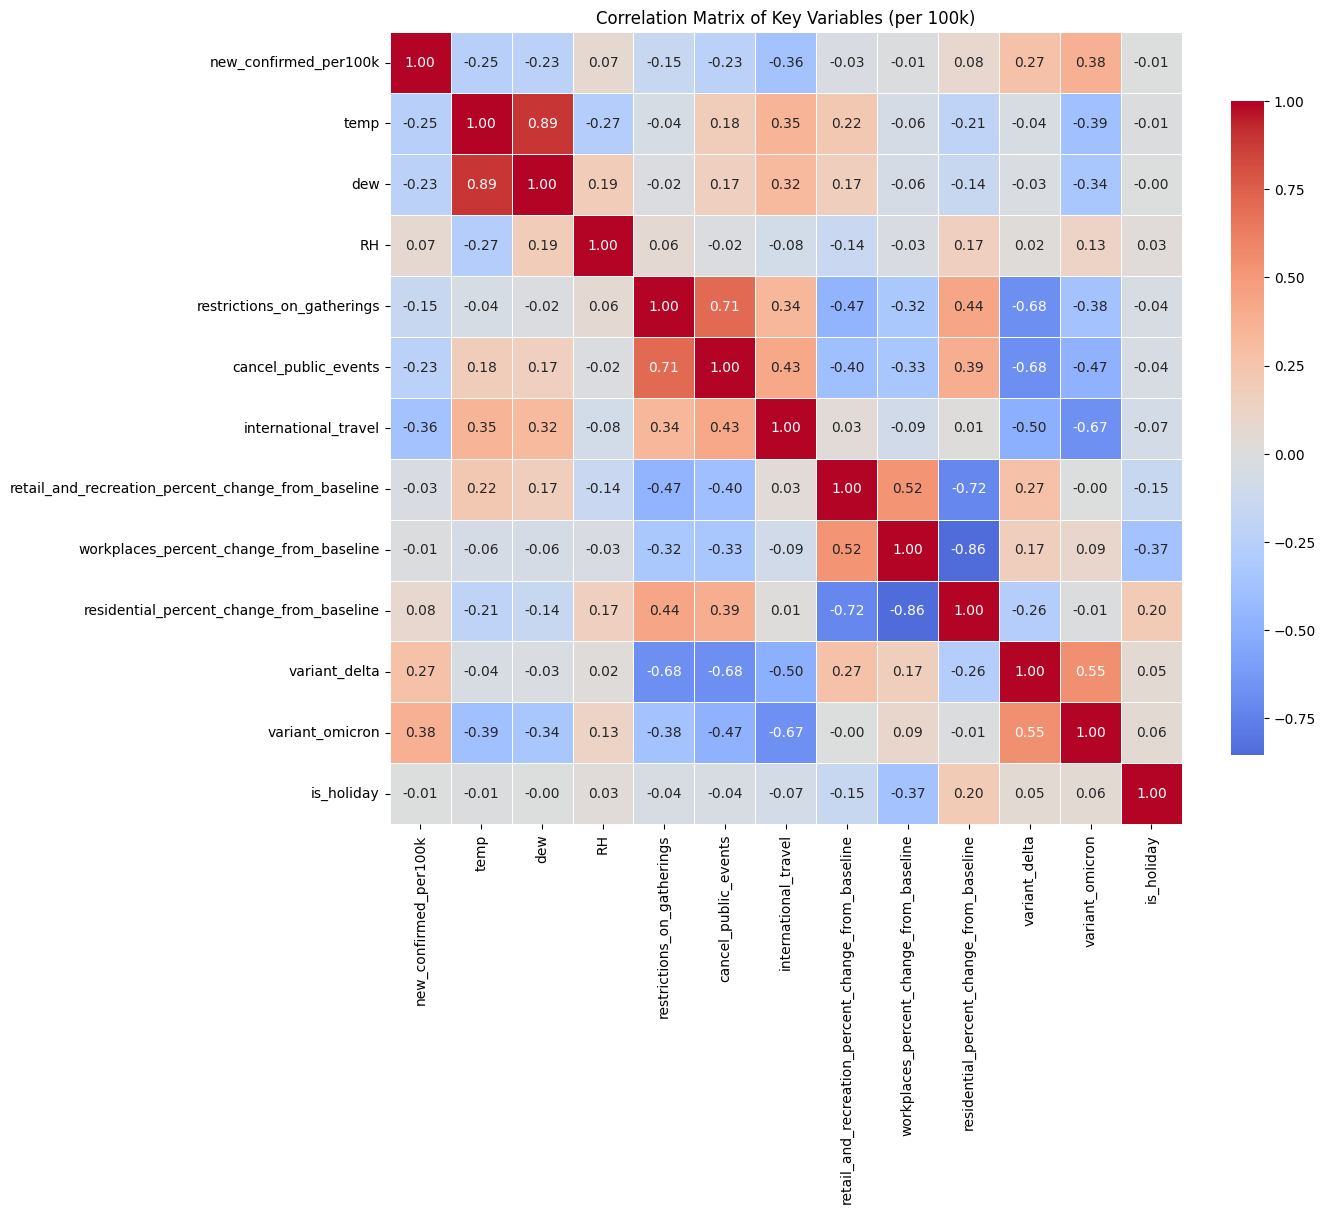

 == 확진자 vs 기후 변수 
new_confirmed_per100k    1.000000
RH                       0.070818
dew                     -0.226151
temp                    -0.252244
Name: new_confirmed_per100k, dtype: float64

 == 확진자 vs 정책 변수 
new_confirmed_per100k         1.000000
restrictions_on_gatherings   -0.149607
cancel_public_events         -0.226324
international_travel         -0.364371
Name: new_confirmed_per100k, dtype: float64

 == 확진자 vs Mobility 변수 
new_confirmed_per100k                                 1.000000
residential_percent_change_from_baseline              0.079763
workplaces_percent_change_from_baseline              -0.008523
retail_and_recreation_percent_change_from_baseline   -0.031789
Name: new_confirmed_per100k, dtype: float64

 == 확진자 vs 변이 변수 
new_confirmed_per100k    1.000000
variant_omicron          0.383118
variant_delta            0.269103
Name: new_confirmed_per100k, dtype: float64


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 분석 대상 컬럼
correlation_cols = [
    'new_confirmed_per100k', 'temp', 'dew', 'RH',
    'restrictions_on_gatherings', 'cancel_public_events', 'international_travel',
    'retail_and_recreation_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'residential_percent_change_from_baseline',
    'variant_delta', 'variant_omicron', 'is_holiday'
]

# 음수 확진자 제거 (0으로 클리핑)
df_corr = df_eda.copy()
df_corr['new_confirmed_per100k'] = df_corr['new_confirmed_per100k'].clip(lower=0)

# 상관행렬
correlation_matrix = df_corr[correlation_cols].corr()

# 상관관계 히트맵
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Key Variables (per 100k)')
plt.tight_layout()
plt.show()

# 세부 상관분석
print(" == 확진자 vs 기후 변수 ")
print(df_corr[['new_confirmed_per100k', 'temp', 'dew', 'RH']].corr()['new_confirmed_per100k'].sort_values(ascending=False))

print("\n == 확진자 vs 정책 변수 ")
print(df_corr[['new_confirmed_per100k', 'restrictions_on_gatherings',
               'cancel_public_events', 'international_travel']].corr()['new_confirmed_per100k'].sort_values(ascending=False))

print("\n == 확진자 vs Mobility 변수 ")
print(df_corr[['new_confirmed_per100k',
               'retail_and_recreation_percent_change_from_baseline',
               'workplaces_percent_change_from_baseline',
               'residential_percent_change_from_baseline']].corr()['new_confirmed_per100k'].sort_values(ascending=False))

print("\n == 확진자 vs 변이 변수 ")
print(df_corr[['new_confirmed_per100k', 'variant_delta', 'variant_omicron']].corr()['new_confirmed_per100k'].sort_values(ascending=False))


## 시계열 패턴 분석

### 변이 출현 전후 주요 변수 변화 분석

변이 출현 전후 주요 변수 변화 (Intervention Analysis)

기간별 주요 변수 평균값:
         기간       확진율        온도        습도    직장 모빌리티   공원 모빌리티    1차 접종률    완전 접종률
  Pre-Delta 20.542048 12.808700 70.692579 -27.772839 49.906430  7.734800  5.955697
  Delta Era 32.099359 18.542552 67.826880 -22.687864 74.053259 43.851996 40.273906
Omicron Era 96.832273  1.712569 76.691864 -22.791054 -0.645833 55.866804 48.755117

변이 출현으로 인한 변화율 (%)

[Delta Era] (vs Pre-Delta)
  확진율                 :   +56.3% ↑
  온도                  :   +44.8% ↑
  습도                  :    -4.1% ↓
  직장 모빌리티             :   +18.3% ↑
  공원 모빌리티             :   +48.4% ↑
  1차 접종률              :  +466.9% ↑
  완전 접종률              :  +576.2% ↑

[Omicron Era] (vs Pre-Delta)
  확진율                 :  +371.4% ↑
  온도                  :   -86.6% ↓
  습도                  :    +8.5% ↑
  직장 모빌리티             :   +17.9% ↑
  공원 모빌리티             :  -101.3% ↓
  1차 접종률              :  +622.3% ↑
  완전 접종률              :  +718.6% ↑


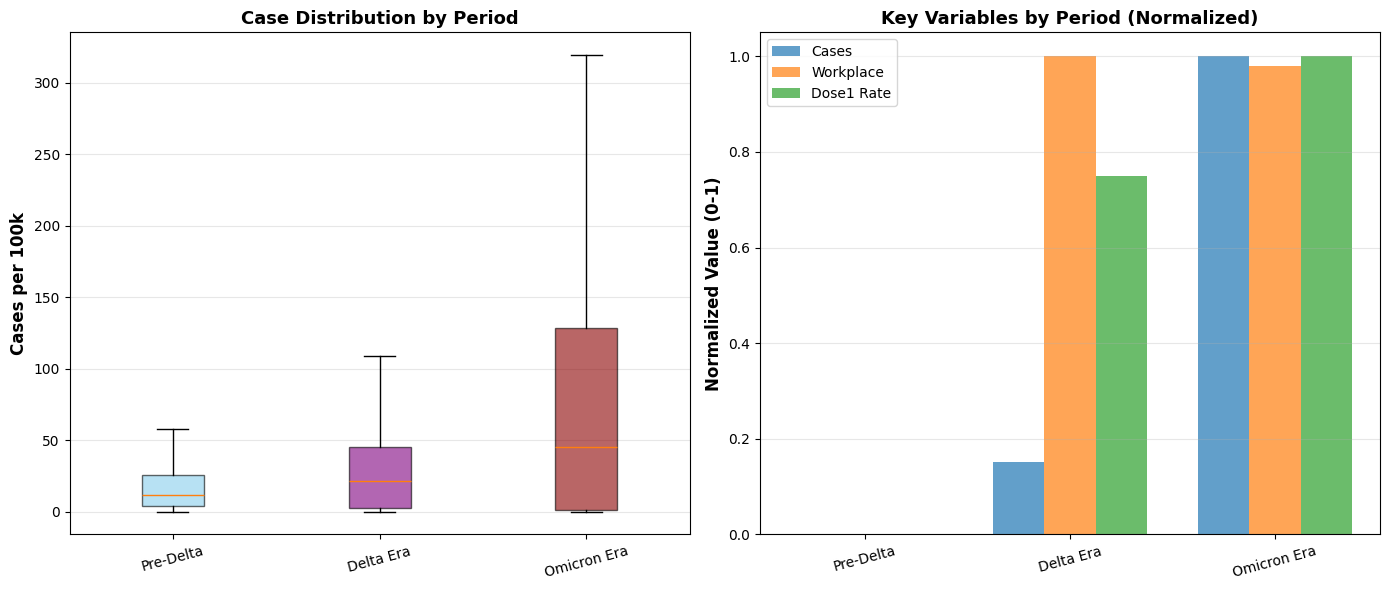


기간 분할 정의:
  - Pre-Delta: 2020-03-01 ~ 2021-06-30
  - Delta Era: 2021-07-01 ~ 2021-11-25
  - Omicron Era: 2021-11-26 ~ 2022-03-01


In [20]:
import pandas as pd
import numpy as np

# 기간 정의
delta_start = pd.to_datetime('2021-07-01')
omicron_start = pd.to_datetime('2021-11-26')

# 3개 기간으로 분할
df_eda['period'] = 'Pre-Delta'
df_eda.loc[df_eda['date'] >= delta_start, 'period'] = 'Delta Era'
df_eda.loc[df_eda['date'] >= omicron_start, 'period'] = 'Omicron Era'

# 기간별 주요 변수 통계
print("="*80)
print("변이 출현 전후 주요 변수 변화 (Intervention Analysis)")
print("="*80)

analysis_vars = {
    '확진율': 'new_confirmed_per100k',
    '온도': 'temp',
    '습도': 'RH',
    '직장 모빌리티': 'workplaces_percent_change_from_baseline',
    '공원 모빌리티': 'parks_percent_change_from_baseline',
    '1차 접종률': 'dose1_rate',
    '완전 접종률': 'fully_vaccinated_rate'
}

period_stats = []
for period in ['Pre-Delta', 'Delta Era', 'Omicron Era']:
    period_data = df_eda[df_eda['period'] == period]
    stats_row = {'기간': period}

    for var_name, var_col in analysis_vars.items():
        if var_col in period_data.columns:
            mean_val = period_data[var_col].mean()
            stats_row[var_name] = mean_val

    period_stats.append(stats_row)

df_period_comparison = pd.DataFrame(period_stats)
print("\n기간별 주요 변수 평균값:")
print(df_period_comparison.to_string(index=False))

# 변화율 계산
print("\n" + "="*80)
print("변이 출현으로 인한 변화율 (%)")
print("="*80)

baseline = df_period_comparison[df_period_comparison['기간'] == 'Pre-Delta'].iloc[0]
for period in ['Delta Era', 'Omicron Era']:
    current = df_period_comparison[df_period_comparison['기간'] == period].iloc[0]
    print(f"\n[{period}] (vs Pre-Delta)")

    for var_name in analysis_vars.keys():
        if var_name in baseline and var_name in current:
            if baseline[var_name] != 0 and not pd.isna(baseline[var_name]) and not pd.isna(current[var_name]):
                change_pct = ((current[var_name] - baseline[var_name]) / abs(baseline[var_name])) * 100
                direction = "↑" if change_pct > 0 else "↓"
                print(f"  {var_name:20s}: {change_pct:+7.1f}% {direction}")

# 시각화: 기간별 확진율 박스플롯
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 기간별 확진율 분포
period_order = ['Pre-Delta', 'Delta Era', 'Omicron Era']
period_colors = ['skyblue', 'purple', 'darkred']

df_eda_boxplot = df_eda[df_eda['new_confirmed_per100k'] >= 0]  # 음수 제거
bp = axes[0].boxplot([df_eda_boxplot[df_eda_boxplot['period'] == p]['new_confirmed_per100k']
                       for p in period_order],
                      tick_labels=period_order,
                      patch_artist=True,
                      showfliers=False)

for patch, color in zip(bp['boxes'], period_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[0].set_ylabel('Cases per 100k', fontsize=12, fontweight='bold')
axes[0].set_title('Case Distribution by Period', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=15)

# 기간별 주요 변수 평균값 막대 그래프
metric_map = {'확진율': 'Cases', '직장 모빌리티': 'Workplace', '1차 접종률': 'Dose1 Rate'}
metrics_korean = ['확진율', '직장 모빌리티', '1차 접종률']
x = np.arange(len(period_order))
width = 0.25

for i, metric_ko in enumerate(metrics_korean):
    if metric_ko in df_period_comparison.columns:
        values = df_period_comparison[metric_ko].values
        # 정규화 (0-1 범위)
        if not pd.isna(values).all() and values.max() != values.min():
            values_norm = (values - values.min()) / (values.max() - values.min())
            axes[1].bar(x + i*width, values_norm, width,
                       label=metric_map[metric_ko], alpha=0.7)

axes[1].set_ylabel('Normalized Value (0-1)', fontsize=12, fontweight='bold')
axes[1].set_title('Key Variables by Period (Normalized)', fontsize=13, fontweight='bold')
axes[1].set_xticks(x + width)
axes[1].set_xticklabels(period_order, rotation=15)
axes[1].legend(fontsize=10)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n기간 분할 정의:")
print(f"  - Pre-Delta: 2020-03-01 ~ 2021-06-30")
print(f"  - Delta Era: 2021-07-01 ~ 2021-11-25")
print(f"  - Omicron Era: 2021-11-26 ~ 2022-03-01")


### 확진자 + 주요 변수 통합 시계열

시계열 패턴 분석: Intervention Analysis 관점

주요 이벤트 시점:
  - Delta Variant: 2021-07-01
  - Omicron Variant: 2021-11-26
  - Vaccination Start: 2020-12-14
  - Booster Start: 2021-09-22


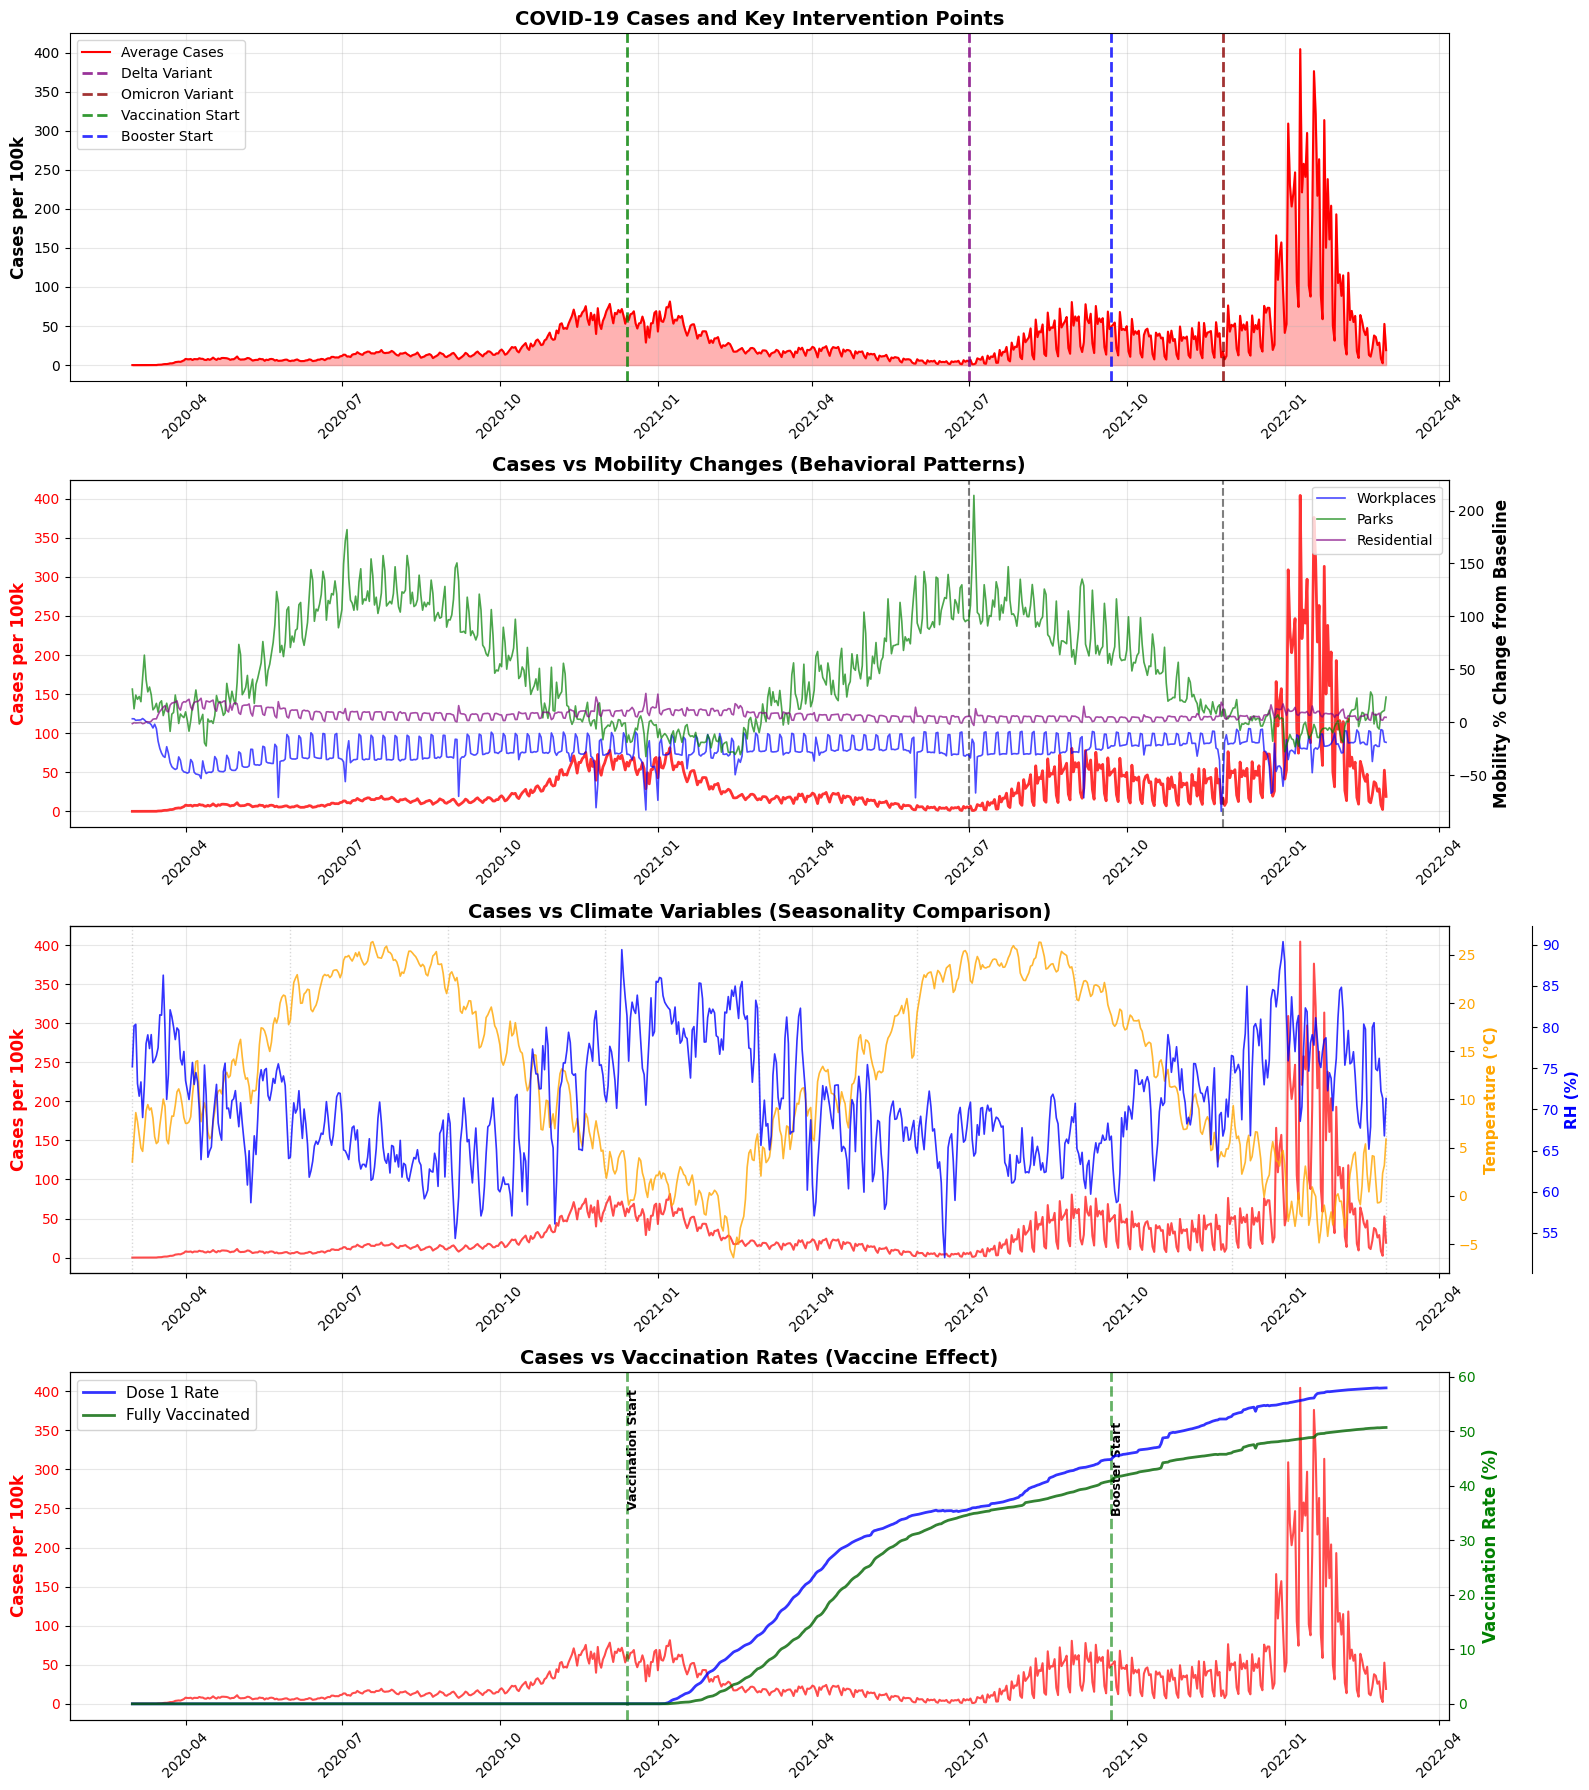


==> Visualization complete: Time-series EDA with Intervention Analysis
 == 연도별 월 평균 확진자 수 
year  month
2020  3          121.0
      4          580.7
      5          449.1
      6          560.0
      7         1198.6
      8          940.4
      9          777.7
      10        1213.0
      11        2922.1
      12        4128.6
2021  1         3870.5
      2         1680.8
      3         1143.4
      4         1218.1
      5          576.3
      6          257.5
      7          833.3
      8         2694.7
      9         2698.5
      10        1585.1
      11        1665.3
      12        3929.3
2022  1        12733.5
      2         2734.3
      3          897.0
Name: new_confirmed, dtype: float64


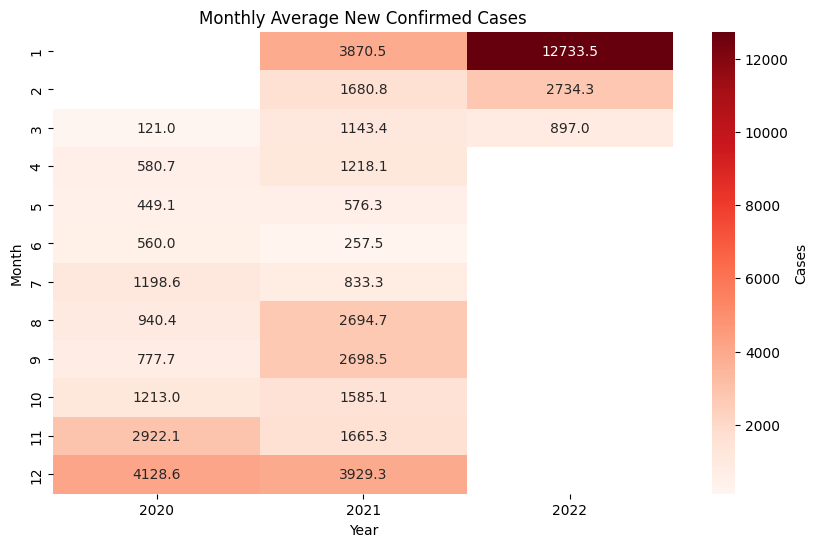

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 주요 이벤트 시점 정의 (Intervention Analysis)
key_events = {
    'Delta Variant': '2021-07-01',
    'Omicron Variant': '2021-11-26',
    'Vaccination Start': '2020-12-14',
    'Booster Start': '2021-09-22'
}

print("="*80)
print("시계열 패턴 분석: Intervention Analysis 관점")
print("="*80)
print("\n주요 이벤트 시점:")
for event, date in key_events.items():
    print(f"  - {event}: {date}")

# 확진자 + 주요 변수 통합 시계열 (4개 서브플롯)
fig, axes = plt.subplots(4, 1, figsize=(16, 18))

# 확진자 추이 + 주요 이벤트 표시
daily_avg = df_eda.groupby('date')['new_confirmed_per100k'].mean()
axes[0].plot(daily_avg.index, daily_avg.values, linewidth=1.5, color='red', label='Average Cases')
axes[0].fill_between(daily_avg.index, daily_avg.values, alpha=0.3, color='red')
axes[0].set_ylabel('Cases per 100k', fontsize=12, fontweight='bold')
axes[0].set_title('COVID-19 Cases and Key Intervention Points', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# 변이 출현 시점 표시
colors_events = {'Delta Variant': 'purple', 'Omicron Variant': 'darkred',
                 'Vaccination Start': 'green', 'Booster Start': 'blue'}
for event_name, event_date in key_events.items():
    event_dt = pd.to_datetime(event_date)
    if event_dt >= daily_avg.index.min() and event_dt <= daily_avg.index.max():
        axes[0].axvline(event_dt, color=colors_events.get(event_name, 'black'),
                       linestyle='--', alpha=0.8, linewidth=2, label=event_name)

axes[0].legend(loc='upper left', fontsize=10)
axes[0].tick_params(axis='x', rotation=45)

# 확진자 + 모빌리티 (Dual Y-axis)
ax1 = axes[1]
ax2 = ax1.twinx()

ax1.plot(daily_avg.index, daily_avg.values, linewidth=2, color='red', label='Cases', alpha=0.8)
ax1.set_ylabel('Cases per 100k', fontsize=12, fontweight='bold', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# 주요 모빌리티 변수
mobility_vars = {'workplaces_percent_change_from_baseline': ('Workplaces', 'blue'),
                 'parks_percent_change_from_baseline': ('Parks', 'green'),
                 'residential_percent_change_from_baseline': ('Residential', 'purple')}

for var, (label, color) in mobility_vars.items():
    if var in df_eda.columns:
        mobility_avg = df_eda.groupby('date')[var].mean()
        ax2.plot(mobility_avg.index, mobility_avg.values, linewidth=1.2,
                label=label, alpha=0.7, color=color)

ax2.set_ylabel('Mobility % Change from Baseline', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10)
ax2.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax1.set_title('Cases vs Mobility Changes (Behavioral Patterns)', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 변이 시점 표시
for event_name, event_date in key_events.items():
    if 'Variant' in event_name:
        event_dt = pd.to_datetime(event_date)
        if event_dt >= daily_avg.index.min() and event_dt <= daily_avg.index.max():
            ax1.axvline(event_dt, color='black', linestyle='--', alpha=0.5, linewidth=1.5)

# 확진자 + 기후 (Triple Y-axis)
ax1 = axes[2]
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))

ax1.plot(daily_avg.index, daily_avg.values, linewidth=1.5, color='red', label='Cases', alpha=0.7)
ax1.set_ylabel('Cases per 100k', fontsize=12, fontweight='bold', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# 기후 변수
temp_avg = df_eda.groupby('date')['temp'].mean()
rh_avg = df_eda.groupby('date')['RH'].mean()

ax2.plot(temp_avg.index, temp_avg.values, linewidth=1.2, label='Temperature', color='orange', alpha=0.8)
ax3.plot(rh_avg.index, rh_avg.values, linewidth=1.2, label='Humidity', color='blue', alpha=0.8)

ax2.set_ylabel('Temperature (°C)', fontsize=11, fontweight='bold', color='orange')
ax3.set_ylabel('RH (%)', fontsize=11, fontweight='bold', color='blue')
ax2.tick_params(axis='y', labelcolor='orange')
ax3.tick_params(axis='y', labelcolor='blue')

# 계절 구분선
for year in [2020, 2021, 2022]:
    for month in [3, 6, 9, 12]:  # Spring, Summer, Fall, Winter
        season_date = pd.to_datetime(f'{year}-{month:02d}-01')
        if season_date >= daily_avg.index.min() and season_date <= daily_avg.index.max():
            ax1.axvline(season_date, color='gray', linestyle=':', alpha=0.3, linewidth=1)

ax1.set_title('Cases vs Climate Variables (Seasonality Comparison)', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 백신 접종률 + 확진자
ax1 = axes[3]
ax2 = ax1.twinx()

ax1.plot(daily_avg.index, daily_avg.values, linewidth=1.5, color='red', label='확진율', alpha=0.7)
ax1.set_ylabel('Cases per 100k', fontsize=12, fontweight='bold', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# 백신 접종률
if 'dose1_rate' in df_eda.columns:
    vaccine_avg = df_eda.groupby('date')['dose1_rate'].mean()
    ax2.plot(vaccine_avg.index, vaccine_avg.values, linewidth=2,
            label='Dose 1 Rate', color='blue', alpha=0.8)
if 'fully_vaccinated_rate' in df_eda.columns:
    vaccine_full = df_eda.groupby('date')['fully_vaccinated_rate'].mean()
    ax2.plot(vaccine_full.index, vaccine_full.values, linewidth=2,
            label='Fully Vaccinated', color='darkgreen', alpha=0.8)

ax2.set_ylabel('Vaccination Rate (%)', fontsize=12, fontweight='bold', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper left', fontsize=11)
ax1.set_title('Cases vs Vaccination Rates (Vaccine Effect)', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 백신 관련 이벤트 표시
for event_name, event_date in key_events.items():
    if 'Vaccination' in event_name or 'Booster' in event_name:
        event_dt = pd.to_datetime(event_date)
        if event_dt >= daily_avg.index.min() and event_dt <= daily_avg.index.max():
            ax1.axvline(event_dt, color='green', linestyle='--', alpha=0.6, linewidth=2)
            y_pos = ax1.get_ylim()[1] * (0.95 if 'Vaccination Start' in event_name else 0.85)
            ax1.text(event_dt, y_pos, event_name, rotation=90,
                    verticalalignment='top', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n==> Visualization complete: Time-series EDA with Intervention Analysis")

#  월별 패턴 분석
df_eda['year'] = df_eda['date'].dt.year
df_eda['month'] = df_eda['date'].dt.month

monthly_pattern = (
    df_eda.groupby(['year', 'month'])['new_confirmed']
    .mean().round(1)
)

print(" == 연도별 월 평균 확진자 수 ")
print(monthly_pattern)

# heatmap 시각화
monthly_pivot = monthly_pattern.unstack(level=0)
plt.figure(figsize=(10, 6))
sns.heatmap(monthly_pivot, annot=True, fmt=".1f", cmap="Reds", cbar_kws={"label": "Cases"})
plt.title("Monthly Average New Confirmed Cases")
plt.xlabel("Year")
plt.ylabel("Month")
plt.show()


## 지역별 분석

 == 주별 확진자 수 통계 (per 100k)
                count   mean     std  min      max  median
state                                                     
Alaska            731  44.63  108.62  0.0  1387.99   11.98
Rhode Island      731  44.37  112.19  0.0  1475.95   12.86
North Dakota      731  41.79   58.81  0.0   398.56   19.15
Tennessee         731  39.32   50.99  0.0   312.37   21.25
Kentucky          731  38.82   67.03  0.0   870.88   17.24
South Carolina    731  38.36   94.10  0.0  1370.01   17.71
Utah              731  37.83   74.43  0.0  1176.11   15.78
West Virginia     731  37.64   54.76  0.0   516.54   17.30
Arizona           731  37.14   55.02  0.0   740.98   20.22
Arkansas          731  37.05   54.99  0.0   475.57   21.50

 == 주별 기후 데이터 통계
                       temp            RH       
                       mean    std   mean    std
state                                           
Alabama               18.36   7.89  74.67  11.21
Alaska                 0.07   7.87  90.42   6.20
Ar

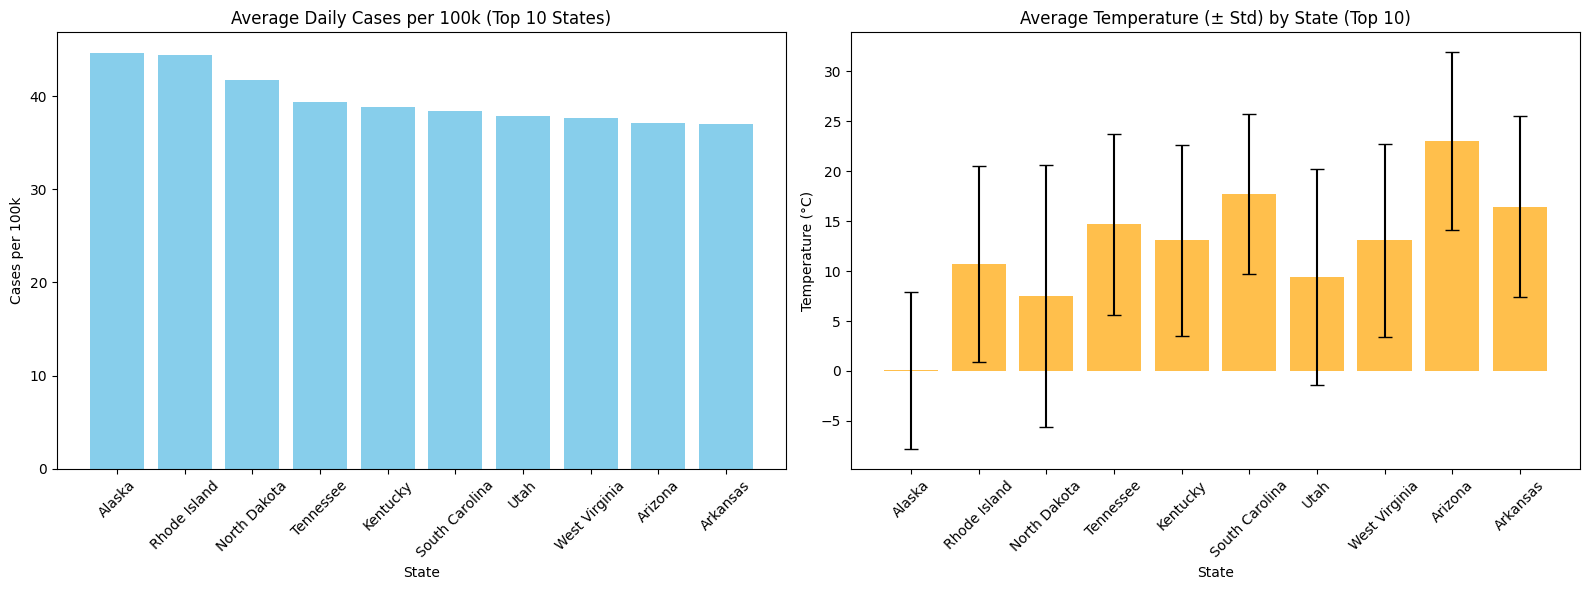

In [22]:
# 주별 확진자 수 통계 (per 100k 기준)
print(" == 주별 확진자 수 통계 (per 100k)")
state_stats = df_eda.groupby('state')['new_confirmed_per100k'].agg([
    'count', 'mean', 'std', 'min', 'max', 'median'
]).round(2)
state_stats = state_stats.sort_values('mean', ascending=False)
print(state_stats.head(10))

# 주별 기후 데이터 통계
print("\n == 주별 기후 데이터 통계")
climate_stats = df_eda.groupby('state')[['temp', 'RH']].agg(['mean', 'std']).round(2)
print(climate_stats.head(10))

# 상위 10개 주 시각화
top_states = state_stats.head(10).index
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 주별 평균 확진자수 per 100k (Top 10)
state_means = df_eda.groupby('state')['new_confirmed_per100k'].mean().sort_values(ascending=False)
axes[0].bar(range(len(top_states)), [state_means[state] for state in top_states], color="skyblue")
axes[0].set_title('Average Daily Cases per 100k (Top 10 States)')
axes[0].set_xlabel('State')
axes[0].set_ylabel('Cases per 100k')
axes[0].set_xticks(range(len(top_states)))
axes[0].set_xticklabels(top_states, rotation=45)

# 주별 평균 기온 + 표준편차
state_temp_mean = df_eda.groupby('state')['temp'].mean().loc[top_states]
state_temp_std = df_eda.groupby('state')['temp'].std().loc[top_states]
axes[1].bar(range(len(top_states)), state_temp_mean.values, yerr=state_temp_std.values,
            color='orange', alpha=0.7, capsize=5)
axes[1].set_title('Average Temperature (± Std) by State (Top 10)')
axes[1].set_xlabel('State')
axes[1].set_ylabel('Temperature (°C)')
axes[1].set_xticks(range(len(top_states)))
axes[1].set_xticklabels(top_states, rotation=45)

plt.tight_layout()
plt.show()


#  Statistical Analysis

##  패널 고정효과 회귀 (Panel Fixed Effects Regression)
- 기후 변수가 COVID-19 확산에 미치는 영향을 추정
- State FE + Time FE로 관측되지 않는 이질성 통제
- 정책 변수를 통제한 상태에서 기후의 순수 효과 파악

In [23]:
pip install linearmodels scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.4 MB/s eta 0:00:00


### 2-Way FE 비교: 기후 미포함 vs 포함(Temp+VPD)

In [24]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS
from scipy.stats import chi2
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

# 변수 정의
policy_vars = [
    "restrictions_on_gatherings",
    "contact_tracing",
    "cancel_public_events",
    "international_travel"  # time FE와 공선성 강함 → 더미 생성 후 제외
]

target_col = "new_confirmed_per100k"

# 입력 DF 준비

df_features = df_features.copy()
df_targets  = df_targets.copy()
df_features["date"] = pd.to_datetime(df_features["date"])
df_targets["date"]  = pd.to_datetime(df_targets["date"])

print(f"정의: 정책 {len(policy_vars)}개 / 타깃='{target_col}'")

# 병합
base_cols = ["state", "date"] + policy_vars + ["temp", "dew", "RH"]

# target_col이 new_confirmed_per100k이면 오른쪽에서 한 번만 선택
if target_col == "new_confirmed_per100k":
    right_cols = ["state", "date", "new_confirmed_per100k"]
else:
    right_cols = ["state", "date", target_col, "new_confirmed_per100k"]

df_panel = (
    pd.merge(df_features[base_cols],
             df_targets[right_cols],
             on=["state", "date"],
             how="inner")
      .sort_values(["state", "date"], ignore_index=True)
)

if not df_panel.columns.is_unique:
    dup_cols = df_panel.columns[df_panel.columns.duplicated()].tolist()
    print("[중복 컬럼 제거]", dup_cols)
    df_panel = df_panel.loc[:, ~df_panel.columns.duplicated()].copy()

# 정책 변수 정리 - 원핫
for c in policy_vars:
    df_panel[c] = pd.to_numeric(df_panel[c], errors="coerce").fillna(0).astype(int)

policy_dummies = []
for p in policy_vars:
    dum = pd.get_dummies(df_panel[p], prefix=p, drop_first=True)
    policy_dummies.append(dum)

policy_dum = pd.concat(policy_dummies, axis=1)
df_panel = pd.concat([df_panel.drop(columns=policy_vars), policy_dum], axis=1)

# 국제이동 제한(international_travel)은 time FE와 공선성 - 제외
policy_cols_expanded = [
    c for c in df_panel.columns
    if any(c.startswith(p + "_")
           for p in ["restrictions_on_gatherings",
                     "contact_tracing",
                     "cancel_public_events"])
]

# 기후 파생지표: VPD(증기압 부족), DPD(참고)
def esat_c(T):
    # 포화수증기압(kPa), T in °C
    return 0.6108 * np.exp((17.27 * T) / (T + 237.3))

es = esat_c(df_panel["temp"])
ea = esat_c(df_panel["dew"])
df_panel["vpd"] = (es - ea) * 10.0
df_panel["dpd"] = df_panel["temp"] - df_panel["dew"]

# 최종 기후 변수(다중공선성 완화): temp + vpd
climate_vars = ["temp", "vpd"]

# AR(1) 랙: 어제의 per100k (누수 방지)
df_panel = df_panel.sort_values(["state", "date"]).copy()
df_panel["y_lag1"] = (
    df_panel.groupby("state")["new_confirmed_per100k"].shift(1)
)

# 날짜 단절 구간에서는 랙 무효화
df_panel["date_diff"] = df_panel.groupby("state")["date"].diff().dt.days
df_panel.loc[df_panel["date_diff"] > 1, "y_lag1"] = np.nan
df_panel = df_panel.drop(columns=["date_diff"])

# 결측 제거 & 패널 인덱스 설정
df_panel[target_col] = pd.to_numeric(df_panel[target_col], errors="coerce")
before = len(df_panel)
df_panel = df_panel.dropna(subset=[target_col, "y_lag1"] + climate_vars + policy_cols_expanded).copy()
after = len(df_panel)
print(f"결측 제거: {before:,} → {after:,} 행")

df_panel = df_panel.set_index(["state", "date"]).sort_index()

# 설계행렬 구성
baseline_feats = ["y_lag1"] + policy_cols_expanded
climate_feats  = climate_vars

y = df_panel[target_col]
X_baseline = df_panel[baseline_feats]
X_climate  = df_panel[baseline_feats + climate_feats]

# 패널 2-way FE 적합
mod_base = PanelOLS(y, X_baseline, entity_effects=True, time_effects=True)
res_base = mod_base.fit(cov_type="clustered", cluster_entity=True, cluster_time=True)

mod_clim = PanelOLS(y, X_climate, entity_effects=True, time_effects=True)
res_clim = mod_clim.fit(cov_type="clustered", cluster_entity=True, cluster_time=True)

print("\n" + "="*90)
print("[Baseline: 정책 + AR(1), 2-way FE | Cluster-robust(entity,time)]")
print("="*90)
print(res_base)
print(f"\nR²_within (Base): {res_base.rsquared_within:.6f}")

print("\n" + "="*90)
print("[+Climate: (temp, vpd) 추가, 2-way FE | Cluster-robust(entity,time)]")
print("="*90)
print(res_clim)
print(f"\nR²_within (+Climate): {res_clim.rsquared_within:.6f}")

# ΔR²_within 보고
delta_r2 = (res_clim.rsquared_within - res_base.rsquared_within)
print(f"\nΔR²_within (Climate 추가): {delta_r2:.8f}")


정의: 정책 4개 / 타깃='new_confirmed_per100k'
결측 제거: 37,281 → 37,230 행

[Baseline: 정책 + AR(1), 2-way FE | Cluster-robust(entity,time)]
                            PanelOLS Estimation Summary                            
Dep. Variable:     new_confirmed_per100k   R-squared:                        0.0034
Estimator:                      PanelOLS   R-squared (Between):              0.3859
No. Observations:                  37230   R-squared (Within):              -0.0076
Date:                   Sun, Oct 12 2025   R-squared (Overall):              0.0750
Time:                           20:23:51   Log-likelihood                -1.952e+05
Cov. Estimator:                Clustered                                           
                                           F-statistic:                      15.638
Entities:                             51   P-value                           0.0000
Avg Obs:                          730.00   Distribution:                 F(8,36442)
Min Obs:                        

모델 개요
- Baseline: 정책 + AR(1) + 2-way FE (주 고정효과 + 시간 고정효과)
- +Climate: Baseline + 기후변수 (temp, vpd)
- 표본: 37,230개 관측치 (51개 주 × 730일)
- 방법: Cluster-robust 표준오차 (주 내 시계열 상관 + 시점 내 횡단면 상관 보정)

결과

1. 모델 적합도
- R² (Within): -0.0076 → 0.0044 (기후 추가 시)
  - ΔR² = +1.2%p (거의 개선 없음)
  - 음수 R²는 모델이 평균보다 예측력이 낮음을 의미
- R² (Overall): 7.5% → 6.6% (오히려 감소)

2. 기후 변수 효과
- 온도 (temp): -0.18명/10만명 per °C (p = 0.238, 비유의)
  - 10°C 변화 시 겨우 1.8명 변화 (평균 38명의 5% 미만)
- 증기압 결핍 (vpd): +0.06명/10만명 per kPa (p = 0.593, 비유의)
- 결론: 기후 효과는 통계적으로 유의하지 않고, 실질적으로도 매우 작음

3. 정책 변수의 역설
- 집합 제한 강화 시 확진자 증가로 나타남 (Level 1: +5.48, p=0.049)
- 원인: 역인과성 (확진자 급증 → 정책 강화)
- 실제 정책 효과는 1-2주 후 나타나지만, 동시 측정으로 인한 내생성 문제



결론

1. 기후는 COVID-19 전파의 주요 동인이 아님
- 통계적으로 유의하지 않음
- 설명력 추가 거의 없음 (ΔR² = 1.2%)
- 실질적 효과 크기 매우 작음

2. R²이 낮은 이유
- 높은 데이터 노이즈 (보고 지연, 주말 효과)
- 누락 변수 (개인 행동, 무증상 감염, 검사율)
- 정책의 내생성 문제

3. 과학적 의의
- Negative Result의 가치: 기후가 주요 요인이 아님을 실증
- 정책 함의: 기후보다 정책과 행동 변화에 집중해야 함


### 기후 변수 결합 유의성 (F-test)

In [25]:
print("\n" + "="*90)
print("[Wald test: Climate block joint significance (cluster-robust)]")
print("="*90)

climate_vars_in_model = [v for v in climate_feats if v in res_clim.params.index]
if len(climate_vars_in_model) == 0:
    print("기후 변수 계수가 모델에 없습니다. (공선성/드랍 여부 확인)")
else:
    b = res_clim.params.loc[climate_vars_in_model].values
    V = res_clim.cov.loc[climate_vars_in_model, climate_vars_in_model].values
    try:
        Vinv = np.linalg.inv(V)
    except np.linalg.LinAlgError:
        Vinv = np.linalg.pinv(V)
    W = float(b.T @ Vinv @ b)
    df_w = len(climate_vars_in_model)
    p_w = 1.0 - chi2.cdf(W, df_w)
    H0 = " = ".join([f"β_{v}" for v in climate_vars_in_model]) + " = 0"
    print(f"H0: {H0}")
    print(f"Wald χ²({df_w}) = {W:.4f}, p-value = {p_w:.6f}")
    print("→ 유의" if p_w < 0.05 else "→ 유의하지 않음")


[Wald test: Climate block joint significance (cluster-robust)]
H0: β_temp = β_vpd = 0
Wald χ²(2) = 1.4067, p-value = 0.494937
→ 유의하지 않음


1. Wald Test의 목적
- 여러 변수의 결합 효과(Joint Effect)를 검정
- 개별 t-test: 각 변수가 따로 유의한지 검정
- Wald test: 변수들이 함께 유의한지 검정

2. 왜 필요한가?
- 온도와 VPD는 개별적으로 유의하지 않을 수 있지만, 함께 유의할 수 있음

3. 귀무가설 (H0)
- H0: β_temp = β_vpd = 0 (두 계수가 동시에 0)
- 대립가설 (H1): 최소 하나는 0이 아님

4. 검정 통계량
- Wald 통계량 (W) = b' V^(-1) b
  - b: 계수 벡터
  - V: 공분산 행렬 (cluster-robust)
- W는 카이제곱 분포를 따름 (자유도 = 변수 개수)

5. 결과 해석
- P-value < 0.05: 기후 변수 블록이 전체적으로 유의
- P-value ≥ 0.05: 기후 변수들이 함께 유의한 효과를 보이지 않음
- 이 검정은 개별 t-test보다 엄격하며, 다중 검정 문제를 완화


### 개별 기후 변수 계수

In [26]:
print("\n" + "="*90)
print("[개별 기후 변수 계수 (cluster-robust)]")
print("="*90)
print(f"{'var':10s} {'beta':>12s} {'SE':>12s} {'t':>9s} {'p':>10s} {'sig':>5s}")
print("-"*62)
for cvar in climate_feats:
    if cvar in res_clim.params.index:
        coef  = res_clim.params[cvar]
        se    = res_clim.std_errors[cvar]
        tstat = res_clim.tstats[cvar]
        pval  = res_clim.pvalues[cvar]
        sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else "." if pval < 0.1 else ""
        print(f"{cvar:10s} {coef:12.4f} {se:12.4f} {tstat:9.2f} {pval:10.6f} {sig:>5s}")

print("\nlegend: *** p<0.001, ** p<0.01, * p<0.05, . p<0.1")



[개별 기후 변수 계수 (cluster-robust)]
var                beta           SE         t          p   sig
--------------------------------------------------------------
temp            -0.1767       0.1496     -1.18   0.237536      
vpd              0.0628       0.1175      0.53   0.593243      

legend: *** p<0.001, ** p<0.01, * p<0.05, . p<0.1


개별 기후 변수 계수 결과 해석

온도 (temp)
- 계수: -0.1767 (p = 0.238, 비유의)
- 의미: 1°C 상승 시 확진율 0.18명/10만명 감소 경향
- 실질 효과: 20°C 변화(겨울→여름) 시 3.6명 감소 (평균 38명의 9.5%)
- 결론: 통계적으로 유의하지 않고, 실질적 효과도 작음

증기압 결핍 (vpd)
- 계수: +0.0628 (p = 0.593, 비유의)
- 의미: VPD 1kPa 증가(건조) 시 확진율 0.06명/10만명 증가 경향
- 실질 효과: 극단적 변화(0→3kPa) 시 겨우 0.18명 증가
- 결론: 통계적으로 전혀 유의하지 않고, 효과 크기 무시할 수준

결론

왜 유의하지 않은가?
- 고정효과 영향: Time FE와 Entity FE가 계절성·지역 차이 대부분 흡수
- 실내 전파 우세: 실외 기후보다 실내 환경이 중요 (HVAC 영향)
- 선형 모델 한계: U자형 등 비선형 관계 포착 못함
- 측정 오차: 주도 단일 지점 데이터의 대표성 한계


## 잔차 진단 (Residual Diagnostics)
- 회귀 모델의 가정 검증 (정규성, 등분산성, 자기상관)
- 이상치 및 영향력 있는 관측치 탐지

### 잔차 기본 통계

In [27]:
import statsmodels.api as sm
from scipy import stats

# Climate 모델의 잔차 추출
residuals = res_clim.resids
print("="*80)
print("[잔차 기본 통계]")
print("="*80)
print(residuals.describe())
print(f"\n왜도(Skewness): {stats.skew(residuals):.4f}")
print(f"첨도(Kurtosis): {stats.kurtosis(residuals):.4f}")


[잔차 기본 통계]
count    3.723000e+04
mean    -3.755971e-16
std      4.580096e+01
min     -4.039787e+02
25%     -1.091918e+01
50%     -2.451895e+00
75%      6.091280e+00
max      1.246246e+03
Name: residual, dtype: float64

왜도(Skewness): 7.2675
첨도(Kurtosis): 144.7260


기본 통계량
- 평균: -3.76e-16 ≈ 0 → 모델 편향 없음 (양호)
- 표준편차: 45.80 → 평균 예측 오차 ±45.80명/10만명
- 범위: [-403.98, 1,246.25] → 극단적 오차 존재 (급격한 아웃브레이크 예측 실패)
- 중앙값: -2.45 → 대부분 작은 오차, 0에 가까움

분포 특성
- 왜도: 7.27 (매우 높음) → 극도로 우측 치우침
  - 의미: 대부분 작은 오차지만, 일부 매우 큰 양수 오차(과소 예측) 존재
  - 원인: 모델이 급격한 확진자 증가를 예측하지 못함
  
- 첨도: 144.73 (정규분포는 3) → 극단값 매우 많음
  - 의미: 대부분 예측 정확하나, 일부에서 매우 큰 오차 발생
  - 원인: 팬데믹의 파동성 (급증/급감 반복)

결론: 모델은 평균적으로 편향 없으나, 극단적 상황(아웃브레이크) 예측에 한계


### 잔차 정규성 검정

In [28]:
# Jarque-Bera 검정
jb_stat, jb_pval = stats.jarque_bera(residuals)
print("="*80)
print("[Jarque-Bera 정규성 검정]")
print("="*80)
print(f"H0: 잔차가 정규분포를 따름")
print(f"JB statistic = {jb_stat:.4f}, p-value = {jb_pval:.6f}")

if jb_pval < 0.05:
    print(" 잔차가 정규분포를 따르지 않음 (p < 0.05)")
else:
    print(" 잔차가 정규분포 가정 만족 (p ≥ 0.05)")

[Jarque-Bera 정규성 검정]
H0: 잔차가 정규분포를 따름
JB statistic = 32819609.3031, p-value = 0.000000
 잔차가 정규분포를 따르지 않음 (p < 0.05)


검정 결과
- JB 통계량: 32,819,609 (매우 큼)
- p-value: 0.000000 (< 0.05)
- 결론: 잔차가 정규분포를 따르지 않음 (강력하게 기각)
- 원인: 왜도 7.27, 첨도 144.73로 정규분포(왜도=0, 첨도=3)와 크게 다름

정규성 위배의 의미
- 계수 추정치: 여전히 불편·일치 추정량 (신뢰 가능)
- Cluster-robust SE: 정규성에 덜 의존하여 강건
- 큰 표본: 중심극한정리로 근사적 유효
- 신뢰구간/검정: 보수적 해석 필요

정규성이 위배되는 이유
- 팬데믹 데이터의 본질적 특성 (모델 문제 아님):
  - 급격한 확진자 증가 (아웃브레이크)
  - 저유행 기간의 0 근접 값
  - 극단값의 빈번한 발생

결론: 정규성 위배는 예상된 결과이며, 계수 해석에는 큰 문제 없음


### 잔차 시각화

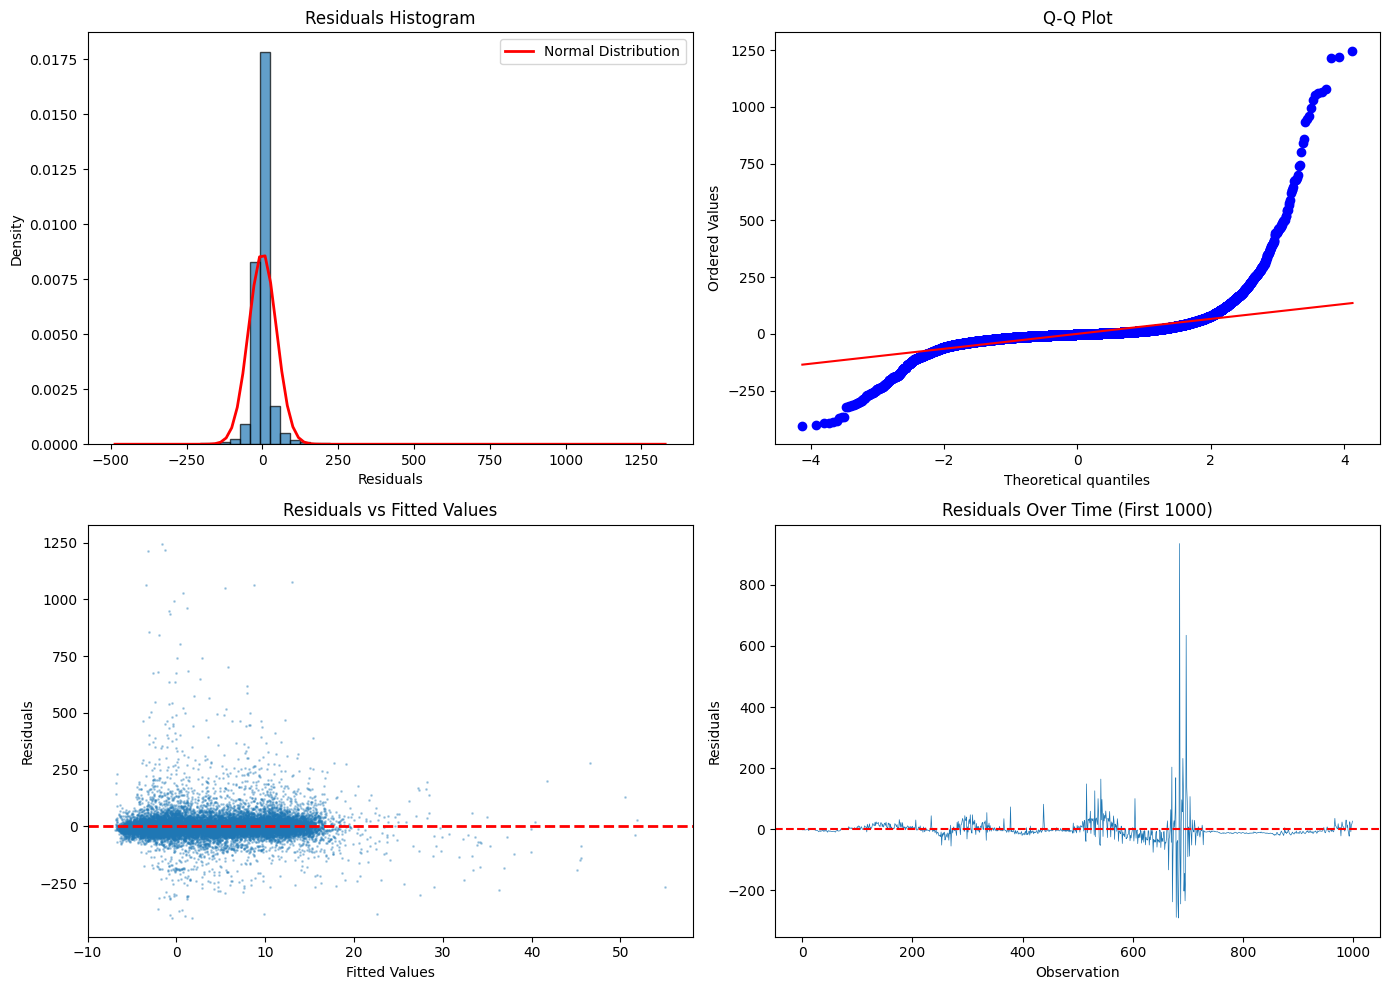

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 잔차 히스토그램 + 정규분포
axes[0, 0].hist(residuals, bins=50, density=True, alpha=0.7, edgecolor='black')
xmin, xmax = axes[0, 0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, residuals.mean(), residuals.std())
axes[0, 0].plot(x, p, 'r-', linewidth=2, label='Normal Distribution')
axes[0, 0].set_title('Residuals Histogram')
axes[0, 0].set_xlabel('Residuals')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot')

# 잔차 vs 적합값
fitted_values = res_clim.predict().fitted_values
axes[1, 0].scatter(fitted_values, residuals, alpha=0.3, s=1)
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Residuals vs Fitted Values')
axes[1, 0].set_xlabel('Fitted Values')
axes[1, 0].set_ylabel('Residuals')

#잔차 시계열 (시간순)
axes[1, 1].plot(residuals.values[:1000], linewidth=0.5)
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title('Residuals Over Time (First 1000)')
axes[1, 1].set_xlabel('Observation')
axes[1, 1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

 1. 잔차 히스토그램
- 중앙 집중: 0 근처에 높은 봉우리 → 대부분 예측 정확
- 긴 꼬리: 우측으로 긴 꼬리 → 일부 매우 큰 양수 오차
- 정규분포 곡선: 빨간 선과 실제 분포가 크게 다름 → 정규성 위배 시각적 확인

 2. Q-Q Plot
- 목적: 잔차가 정규분포를 따르는지 시각적 검정
- 기준: 점들이 대각선을 따라야 정규분포
- 실제 패턴:
  - 중앙 부분은 대각선 근처 (대부분 관측치는 정규 분포에 가까움)
  - 우측 끝이 크게 벗어남 (극단적 양수 오차, Fat tail)
- 정규분포 가정 위배, 특히 극값에서 심함

 3. 잔차 vs 적합값
- 목적: 등분산성(Homoscedasticity) 검증
- 기준: 점들이 0 주변에 무작위로 균일하게 분포해야 함
- 실제 패턴:
  - 대부분 0 근처에 집중 (양호)
  - 일부 극단적 이상치 존재
  - 특정 패턴 없음 → 등분산성 대체로 만족
- 이분산성 문제는 크지 않음

 4. 잔차 시계열
- 목적: 시계열 자기상관 확인
- 패턴:
  - 대부분 0 근처에서 무작위 변동
  - 일부 급격한 스파이크 (아웃브레이크 시점)

- AR(1) 항과 Fixed Effects로 대부분의 자기상관 제거됨
- 극단적 이벤트는 여전히 예측 어려움

결론
- 편향 없음: 평균 0 주변 분포
- 등분산성: 대체로 만족
- 정규성: 명확히 위배 (극값 많음)
- 예측 한계: 극단적 아웃브레이크는 예측 불가
-  Cluster-robust SE 사용으로 정규성 위배 문제 완화, 계수 해석은 유효


## Granger 인과성 검정 (Granger Causality Test)
- 기후 변수가 확진자 수를 **예측하는 데 도움이 되는지** 검정
- 시계열적 인과 관계 탐색 (상관관계를 넘어선 예측력)


### 개별 기후 변수 Granger 검정

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

# 타겟과 기후 변수 병합 (날짜순 정렬)
df_granger = df_panel.reset_index()[["state", "date", target_col] + climate_vars].sort_values(["state", "date"])

max_lag = 14  # 최대 14일 시차까지

for cvar in climate_vars:
    print("="*80)
    print(f"[{cvar} → {target_col}]")
    print(f"{'='*80}")

    # 각 주별로 검정 후 p-value 수집
    pvalues_by_lag = {lag: [] for lag in range(1, max_lag+1)}

    for state in df_granger['state'].unique():
        state_data = df_granger[df_granger['state'] == state][[cvar,'new_confirmed_per100k']].dropna()

        if len(state_data) < 50:  # 최소 샘플 확보
            continue

        try:
            gc_result = grangercausalitytests(state_data, maxlag=max_lag, verbose=False)

            for lag in range(1, max_lag+1):
                pval = gc_result[lag][0]['ssr_ftest'][1]  # F-test p-value
                pvalues_by_lag[lag].append(pval)
        except:
            continue

    # 각 lag별 평균 p-value
    print(f"\n{'Lag':>5s} {'평균 p-value':>15s} {'유의 주수/전체':>18s} {'판정':>10s}")
    print("-" * 55)

    for lag in range(1, max_lag+1):
        if len(pvalues_by_lag[lag]) > 0:
            avg_pval = np.mean(pvalues_by_lag[lag])
            sig_count = sum(p < 0.05 for p in pvalues_by_lag[lag])
            total = len(pvalues_by_lag[lag])
            sig = "O" if avg_pval < 0.05 else "X"
            print(f"{lag:5d} {avg_pval:15.4f} {sig_count:8d}/{total:<8d} {sig:>10s}")

[temp → new_confirmed_per100k]

  Lag      평균 p-value           유의 주수/전체         판정
-------------------------------------------------------
    1          0.2066       24/51                X
    2          0.1417       29/51                X
    3          0.1309       28/51                X
    4          0.1438       29/51                X
    5          0.1648       27/51                X
    6          0.1694       29/51                X
    7          0.1498       29/51                X
    8          0.1420       33/51                X
    9          0.1494       32/51                X
   10          0.1567       32/51                X
   11          0.1285       30/51                X
   12          0.1280       31/51                X
   13          0.1416       32/51                X
   14          0.1420       31/51                X
[vpd → new_confirmed_per100k]

  Lag      평균 p-value           유의 주수/전체         판정
-------------------------------------------------------
    1  

검정 결과

온도 (temp)
- Lag 1-14: 평균 p-value 0.13-0.21 (모두 > 0.05, 비유의)
- 유의한 주: 24-33개/51개 (전체 평균으로는 비유의)

증기압 결핍 (vpd)
- Lag 1-2: p-value 0.15-0.21
- Lag 3-14: p-value 0.33 → 0.94로 급증 (예측력 완전 소멸)
- 유의한 주: Lag 3 이후 0개

결론

1. 기후는 COVID-19를 예측하지 못함
- 온도, VPD 모두 모든 시차(1-14일)에서 비유의
- 잠복기(5-14일) 고려해도 예측력 없음
- 기후 기반 조기 경보 시스템은 효과적이지 않을 것

2. 패널 회귀와 일관된 결과
- 패널 회귀: 기후 효과 비유의 (동시적 관계)
- Granger 검정: 예측력 없음 (시차적 관계)
- 양방향 모두 기후 효과 미미 확인

### Fisher 결합 p-value (주별 통합)

In [ ]:
from scipy.stats import combine_pvalues
from statsmodels.stats.multitest import multipletests

all_results = []

for cvar in climate_vars:
    for state in df_granger['state'].unique():
        state_data = df_granger[df_granger['state'] == state][[cvar, target_col]].dropna()
        if len(state_data) < 50:
            continue

        try:
            gc_result = grangercausalitytests(state_data, maxlag=7, verbose=False)
            pvals = [gc_result[lag][0]['ssr_ftest'][1] for lag in range(1, 8)]

            fisher_stat, fisher_pval = combine_pvalues(pvals, method='fisher')
            all_results.append((cvar, state, fisher_pval))
        except:
            continue

# DataFrame 변환
import pandas as pd
df_fisher = pd.DataFrame(all_results, columns=["variable","state","fisher_pval"])

# FDR 보정
df_fisher["fdr_pval"] = multipletests(df_fisher["fisher_pval"], method="fdr_bh")[1]
df_fisher["sig"] = df_fisher["fdr_pval"] < 0.05

print(df_fisher.head())


  variable       state   fisher_pval      fdr_pval    sig
0     temp     Alabama  3.440101e-11  5.012718e-10   True
1     temp      Alaska  2.617835e-03  7.026821e-03   True
2     temp     Arizona  3.527624e-01  4.797568e-01  False
3     temp    Arkansas  3.834226e-04  1.222160e-03   True
4     temp  California  8.804178e-01  9.999736e-01  False


주별 통합 검정 결과
- Alabama, Alaska, Arkansas: 유의 (True)
- Arizona, California: 비유의 (False)
- 유의한 주: 약 40-60% (20-30개/51개)


- 주별 이질성: 기후 효과가 주마다 크게 다름
  - 원인: 지리적 다양성, 실내 활동 비율, 정책 반응 차이
- 결론: 기후 효과는 지역 특정적이며 보편적이지 않음
- 함의: 미국 전체 기후 기반 예측 시스템 구축 어려움

## 일반화 가법 모델 (GAM - Generalized Additive Model)
- 기후 변수의 **비선형 효과** 추정
- 선형 회귀의 제약 완화 (U자형, 역U자형 관계 포착)

### GAM 모델 적합

In [ ]:
pip install pygam

In [ ]:
from pygam import LinearGAM, s, l
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd

# GAM 데이터 준비 (동일)
target_col = "new_confirmed_per100k"

if target_col == "new_confirmed_per100k":
    cols_needed = ["state", "date", "new_confirmed_per100k"] + climate_vars
else:
    cols_needed = ["state", "date", target_col, "new_confirmed_per100k"] + climate_vars

tmp = (
    df_panel.reset_index()[cols_needed]
            .sort_values(["state","date"])
            .copy()
)

tmp["y_lag1"] = tmp.groupby("state")[target_col].shift(1)
tmp["month"] = tmp["date"].dt.month

X_lin = pd.get_dummies(tmp[["state","month"]], drop_first=True)
X_gam_df = pd.concat(
    [tmp[climate_vars], tmp[["y_lag1"]], X_lin],
    axis=1
).dropna()

y_gam = tmp.loc[X_gam_df.index, target_col].values
X_gam = X_gam_df.values


# 변수명 매핑 생성
feature_names = X_gam_df.columns.tolist()
feature_map = {i: name for i, name in enumerate(feature_names)}

print(f"GAM 데이터: {len(y_gam):,} rows  |  features={X_gam.shape[1]}")
print("\n변수 구성:")
print(f"  - 스플라인: {feature_names[0]}, {feature_names[1]}")
print(f"  - AR(1): {feature_names[2]}")
print(f"  - State 더미: {len([f for f in feature_names if 'state_' in f])}개")
print(f"  - Month 더미: {len([f for f in feature_names if 'month_' in f])}개")

# GAM 적합
terms = s(0) + s(1)
for i in range(2, X_gam.shape[1]):
    terms += l(i)

gam = LinearGAM(terms).gridsearch(X_gam, y_gam, lam=np.logspace(-3, 3, 7))

y_pred_gam = gam.predict(X_gam)
r2_gam = r2_score(y_gam, y_pred_gam)
rmse_gam = np.sqrt(mean_squared_error(y_gam, y_pred_gam))

print("\n" + "="*80)
print("GAM 모델 결과 요약")
print("="*80)
print(f"{'항목':<30} {'값':>15}")
print("-"*80)
print(f"{'샘플 수':<30} {len(y_gam):>15,}")
print(f"{'Feature 수':<30} {X_gam.shape[1]:>15}")
print(f"{'Effective DoF':<30} {gam.statistics_['edof']:>15.2f}")
print(f"{'R² (Pseudo)':<30} {r2_gam:>15.4f}")
print(f"{'RMSE':<30} {rmse_gam:>15.2f}")
print(f"{'AIC':<30} {gam.statistics_['AIC']:>15.2f}")
print(f"{'GCV':<30} {gam.statistics_['GCV']:>15.2f}")


print("\n" + "="*80)
print("주요 변수 효과 (p < 0.1)")
print("="*80)
print(f"{'변수':<40} {'Type':<10} {'p-value':>12} {'Sig':>5}")
print("-"*80)

# p-value 추출
p_values = gam.statistics_['p_values']

# 유의한 변수만 (p < 0.1)
significant = []
for i, (pval, name) in enumerate(zip(p_values, feature_names)):
    if pval < 0.1:
        if i == 0:
            var_type = "Spline"
        elif i == 1:
            var_type = "Spline"
        elif i == 2:
            var_type = "Linear"
        else:
            var_type = "Linear"

        sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else "."


        display_name = name if len(name) <= 38 else name[:35] + "..."

        significant.append((display_name, var_type, pval, sig))

# p-value 순 정렬
significant.sort(key=lambda x: x[2])

for name, vtype, pval, sig in significant[:15]:  # 상위 15개만
    print(f"{name:<40} {vtype:<10} {pval:>12.6f} {sig:>5}")

if len(significant) > 15:
    print(f"\n... 외 {len(significant)-15}개 유의 변수 생략")

print("\nSig: *** p<0.001, ** p<0.01, * p<0.05, . p<0.1")

# 기후 변수 요약
print("\n" + "="*80)
print("기후 변수 효과 (비선형 스플라인)")
print("="*80)

climate_idx = [0, 1]  # temp, vpd
climate_names = [feature_names[i] for i in climate_idx]
climate_pvals = [p_values[i] for i in climate_idx]

for name, pval in zip(climate_names, climate_pvals):
    sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else "." if pval < 0.1 else ""
    print(f"  {name:<10} : p = {pval:.6f} {sig:>5}")
    print(f"             → 비선형 효과 {'유의함' if pval < 0.05 else '있음 (약함)'}")

# AR(1) 효과
print("\n" + "="*80)
print("AR(1) 효과")
print("="*80)
y_lag1_pval = p_values[2]
sig = "***" if y_lag1_pval < 0.001 else "**" if y_lag1_pval < 0.01 else "*"
print(f"  y_lag1 (어제 확진자): p = {y_lag1_pval:.6f} {sig}")
print(f"  → 과거 확진자가 강력한 예측 변수임")



GAM 데이터: 37,179 rows  |  features=54

변수 구성:
  - 스플라인: temp, vpd
  - AR(1): y_lag1
  - State 더미: 50개
  - Month 더미: 0개


100% (7 of 7) |##########################| Elapsed Time: 0:00:41 Time:  0:00:41



GAM 모델 결과 요약
항목                                           값
--------------------------------------------------------------------------------
샘플 수                                    37,179
Feature 수                                   54
Effective DoF                            61.13
R² (Pseudo)                             0.2010
RMSE                                     58.06
AIC                                  672582.97
GCV                                    3386.00

주요 변수 효과 (p < 0.1)
변수                                       Type            p-value   Sig
--------------------------------------------------------------------------------
temp                                     Spline         0.000000   ***
y_lag1                                   Linear         0.000000   ***
vpd                                      Spline         0.000000   ***
state_Vermont                            Linear         0.000000   ***
state_Maine                              Linear         0.000000   ***
st

모델 적합도
- R² (Pseudo): 0.2010 (20.1%)
  - 확진자 변동의 20%를 설명 (일일 데이터 노이즈 고려 시 합리적)
- RMSE: 58.06 (패널 회귀 45.80보다 약간 높음)
- Effective DoF: 61.13 (스플라인으로 인한 복잡도 증가)

기후 변수 효과
- temp (온도): p < 0.001 (*) - 비선형 효과 통계적으로 유의
- vpd (증기압 결핍): p < 0.001 (*) - 비선형 효과 통계적으로 유의
- AR(1): p < 0.001 (*) - 과거 확진자가 강력한 예측 변수


1. 선형 vs 비선형 비교
- 패널 회귀 (선형): 기후 효과 비유의 (p > 0.2)
- GAM (비선형): 기후 효과 통계적으로 유의 (p < 0.001)
- 결론: 기후-확진자 관계는 비선형이며, 선형 모델로는 포착 불가

2. 그러나 실질적 효과는 여전히 작음
- R² 20%는 여전히 낮은 설명력
- 비선형 효과가 통계적으로 유의하지만, 예측력은 제한적
- 대부분의 변동은 State 더미, AR(1), 기타 요인이 설명

3. 함의
- 기후 효과는 존재하지만 복잡하고 미묘함 (비선형, U자형 등)
- 단순 선형 관계 가정은 부적절
- 그러나 정책·행동 변화보다는 여전히 작은 영향

5. GCV (Generalized Cross-Validation)
- 값: 약 3,386
- 의미: 교차 검증을 통한 예측 오차 추정치
- gridsearch 과정에서 이 값을 최소화하는 lambda를 선택
- 과적합을 방지하면서 적합도를 최대화함


### 부분 의존성 그래프 (Partial Dependence)

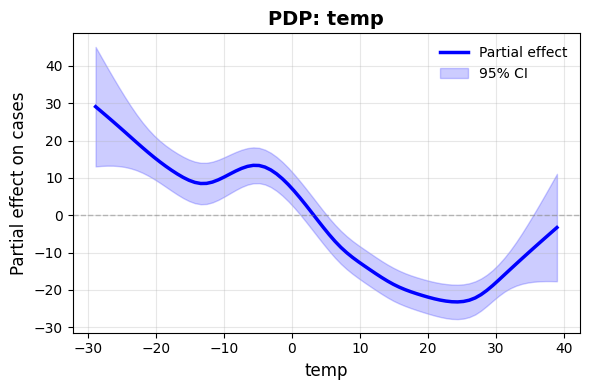

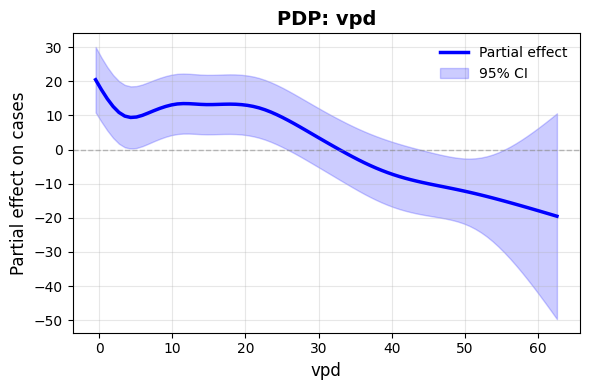

In [ ]:
def plot_pdp_clean(term_id, feature_name, n=80):
    XX = gam.generate_X_grid(term=term_id, n=n)
    pdep, confi = gam.partial_dependence(term=term_id, X=XX, width=0.95)

    col_idx = X_gam_df.columns.get_loc(feature_name)
    x = XX[:, col_idx]

    order = np.argsort(x)
    x = x[order]
    y = pdep[order]

    if confi.ndim == 2:
        if confi.shape[0] == 2:
            low, high = confi[0, order], confi[1, order]
        elif confi.shape[1] == 2:
            low, high = confi[order, 0], confi[order, 1]
        else:
            low, high = y, y
    else:
        low, high = y, y

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(x, y, 'b-', lw=2.5, label='Partial effect')
    ax.fill_between(x, low, high, alpha=0.2, color='blue', label='95% CI')
    ax.axhline(0, color='gray', linestyle='--', lw=1, alpha=0.5)
    ax.set_title(f'PDP: {feature_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel(feature_name, fontsize=12)
    ax.set_ylabel('Partial effect on cases', fontsize=12)
    ax.legend(frameon=False)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# 기후 변수 PDP
for i, cname in enumerate(climate_names):
    plot_pdp_clean(i, cname)



 온도 (temp) PDP
- 패턴: 약한 비선형 관계 (명확한 U자형 아님)
- 신뢰구간: 넓음 → 불확실성 높음
- 해석: 통계적으로 유의(p < 0.001)하나 실질적 효과 작음
- 원인: 실내 전파 우세, 주별 이질성, 계절 효과가 더미에 흡수

 증기압 결핍 (vpd) PDP
- 패턴: 약한 U자형 (중간 VPD에서 최저)
- 신뢰구간: 매우 넓음 → 불확실성 매우 높음
- 해석: 통계적으로 유의하나 효과 미약

결론
- 비선형 효과: 통계적 유의하나 곡선 변동 폭 작고 예측력 제한적
- 선형 vs 비선형: 패널 회귀(비유의) vs GAM(유의하지만 작음)
- 함의: 기후 효과는 존재하되 복잡하고 미약, 정책·행동·백신이 훨씬 중요


### GAM vs PanelOLS 비교

In [ ]:
print("\n" + "="*80)
print("[모델 성능 비교]")
print("="*80)
print(f"{'모델':20s} {'R²':>10s} {'설명':>40s}")
print("-" * 80)
print(f"{'PanelOLS (within)':20s} {res_clim.rsquared_within:10.4f} {'선형, 고정효과 통제':>40s}")
print(f"{'GAM':20s} {r2_gam:10.4f} {'비선형, 고정효과 미통제':>40s}")
print("\n GAM은 비선형 패턴을 포착하지만, 패널 구조를 고려하지 않음")
print(" PanelOLS는 선형이지만, state/time FE로 이질성 통제")


[모델 성능 비교]
모델                           R²                                       설명
--------------------------------------------------------------------------------
PanelOLS (within)        0.0044                              선형, 고정효과 통제
GAM                      0.2010                            비선형, 고정효과 미통제

 GAM은 비선형 패턴을 포착하지만, 패널 구조를 고려하지 않음
 PanelOLS는 선형이지만, state/time FE로 이질성 통제


# Machine Learning & Feature Importance

## 최적 모델 선정


In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.base import clone
from sklearn.metrics import mean_squared_log_error, median_absolute_error

target = "target_7d"

# 병합 전에 date 컬럼 타입 통일
df_ml["date"] = pd.to_datetime(df_ml["date"])
df_targets["date"] = pd.to_datetime(df_targets["date"])

# 병합
df_all = df_ml.merge(
    df_targets[["state", "date", target]],
    on=["state", "date"],
    how="inner"
).sort_values(["state","date"])

print(f"병합 완료: {len(df_all):,} rows")
print(f"   컬럼 수: {len(df_all.columns)}")
print(f"   타겟 변수: {target}")

# 전체 데이터 사용
df_all["date"] = pd.to_datetime(df_all["date"])
print(f"전체 데이터 사용: {len(df_all):,} rows")
print(f"   기간: {df_all['date'].min()} ~ {df_all['date'].max()}")

# 타겟 변수 로그 변환
df_all[target] = df_all[target].clip(lower=0)  # 음수 제거
df_all[f"{target}_log"] = np.log1p(df_all[target])

print(f"\n 타겟 변수 분포:")
print(f"   원본: min={df_all[target].min():.2f}, max={df_all[target].max():.2f}, mean={df_all[target].mean():.2f}")
print(f"   로그: min={df_all[f'{target}_log'].min():.2f}, max={df_all[f'{target}_log'].max():.2f}, mean={df_all[f'{target}_log'].mean():.2f}")

# Train/Val/Test 분할 (전체 데이터 기준)
dates = sorted(df_all["date"].unique())
n = len(dates)
train_end = dates[int(n*0.75) - 1]
val_end   = dates[int(n*0.90) - 1]

df_train = df_all[df_all["date"] <= train_end].copy()
df_val   = df_all[(df_all["date"] > train_end) & (df_all["date"] <= val_end)].copy()
df_test  = df_all[df_all["date"] > val_end].copy()

print(f"\n데이터 분할:")
print(f"   Train: {df_train.shape} ({df_train['date'].min()} ~ {df_train['date'].max()})")
print(f"   Val:   {df_val.shape} ({df_val['date'].min()} ~ {df_val['date'].max()})")
print(f"   Test:  {df_test.shape} ({df_test['date'].min()} ~ {df_test['date'].max()})")


# Feature/Target 분리
target_log = f"{target}_log"

# 제외할 컬럼 정의
exclude_cols = ["date", "state", target, target_log]


X_train = df_train.drop(columns=exclude_cols, errors="ignore")
y_train = df_train[target_log]
y_train_orig = df_train[target]

X_val = df_val.drop(columns=exclude_cols, errors="ignore")
y_val = df_val[target_log]
y_val_orig = df_val[target]

X_test = df_test.drop(columns=exclude_cols, errors="ignore")
y_test = df_test[target_log]
y_test_orig = df_test[target]

print(f"\nFeature 준비:")
print(f"   Feature 개수: {len(X_train.columns)}")
print(f"   Feature 예시: {list(X_train.columns[:10])}")

# 모델 정의
models = {
    "RandomForest": RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_leaf=10,
        random_state=42,
        n_jobs=-1
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=10,
        num_leaves=31,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=10,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )
}

# Rolling-Origin CV

def rolling_origin_indices(df, date_col, n_splits=5, val_days=28, gap_days=21, min_train_days=120):
    dmin, dmax = df[date_col].min(), df[date_col].max()
    cutpoints = pd.date_range(
        start=dmin + pd.Timedelta(days=min_train_days),
        end=dmax - pd.Timedelta(days=val_days + gap_days),
        periods=n_splits
    )
    for cut in cutpoints:
        train_end = cut
        val_start = train_end + pd.Timedelta(days=gap_days)
        val_end   = val_start + pd.Timedelta(days=val_days)
        tr_idx = df.index[(df[date_col] <= train_end)]
        va_idx = df.index[(df[date_col] > val_start) & (df[date_col] <= val_end)]
        if len(tr_idx) == 0 or len(va_idx) == 0:
            continue
        yield tr_idx, va_idx

print("\n" + "="*80)
print("교차 검증 시작 (Log-transformed Target)")
print("="*80)

cv_results = []
for model_name, model_template in models.items():
    print(f"\n {model_name} ")
    fold_metrics = []

    for i, (tr_idx, va_idx) in enumerate(
        rolling_origin_indices(df_train, "date", n_splits=5, val_days=28, gap_days=21)
    ):
        X_tr, y_tr = X_train.loc[tr_idx], y_train.loc[tr_idx]
        X_va, y_va = X_train.loc[va_idx], y_train.loc[va_idx]
        y_va_orig = y_train_orig.loc[va_idx]

        # NaN 제거
        tr_mask = X_tr.notna().all(axis=1) & y_tr.notna()
        va_mask = X_va.notna().all(axis=1) & y_va.notna()
        X_tr, y_tr = X_tr[tr_mask], y_tr[tr_mask]
        X_va, y_va = X_va[va_mask], y_va[va_mask]
        y_va_orig = y_va_orig[va_mask]

        if len(y_tr) < 100 or len(y_va) < 50:
            print(f"Fold {i+1}: 데이터 부족 (train={len(y_tr)}, val={len(y_va)}) → 건너뜀")
            continue

        model = clone(model_template)
        model.fit(X_tr, y_tr)

        # 예측 (로그 → 원본 변환)
        pred_log = model.predict(X_va)
        pred_orig = np.expm1(pred_log)
        pred_orig = np.clip(pred_orig, 0, None)

        # 원본 공간에서 평가
        rmse = np.sqrt(mean_squared_error(y_va_orig, pred_orig))
        mae  = mean_absolute_error(y_va_orig, pred_orig)
        r2   = r2_score(y_va_orig, pred_orig)

        # MAPE
        mask_nonzero = y_va_orig > 0
        mape = np.nan
        if mask_nonzero.sum() > 0:
            mape = 100 * np.mean(np.abs((y_va_orig[mask_nonzero] - pred_orig[mask_nonzero]) / y_va_orig[mask_nonzero]))

        # MedAE
        medae = median_absolute_error(y_va_orig, pred_orig)

        print(f"Fold {i+1}: RMSE={rmse:7.2f}, MAE={mae:7.2f}, R²={r2:6.4f}, MAPE={mape:6.2f}%, MedAE={medae:7.2f}, n={len(y_va)}")
        fold_metrics.append({
            "rmse": rmse, "mae": mae, "r2": r2, "mape": mape,
            "medae": medae, "n": len(y_va)
        })

    # 가중 평균
    if fold_metrics:
        w = np.array([m["n"] for m in fold_metrics], dtype=float)
        w /= w.sum()
        rmse_mean = float(np.sum(w * np.array([m["rmse"] for m in fold_metrics])))
        mae_mean  = float(np.sum(w * np.array([m["mae"]  for m in fold_metrics])))
        r2_mean   = float(np.sum(w * np.array([m["r2"]   for m in fold_metrics])))
        mape_mean = float(np.nanmean([m["mape"] for m in fold_metrics]))
        medae_mean = float(np.nanmean([m["medae"] for m in fold_metrics]))
    else:
        rmse_mean = mae_mean = r2_mean = mape_mean = medae_mean = np.nan

    cv_results.append({
        "Model": model_name,
        "RMSE": rmse_mean,
        "MAE": mae_mean,
        "R²": r2_mean,
        "MAPE(%)": mape_mean,
        "MedAE": medae_mean
    })

df_cv_results = pd.DataFrame(cv_results).sort_values("R²", ascending=False)
print("\n" + "="*80)
print("CV 결과 요약 (Log Target)")
print("="*80)
print(df_cv_results.to_string(index=False))

# 최적 모델 Test 평가
best_model_name = df_cv_results.iloc[0]["Model"]
print(f"\n최적 모델: {best_model_name}")

best_model = models[best_model_name]

# Train+Val 학습
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)
mask = X_trainval.notna().all(axis=1) & y_trainval.notna()
X_trainval, y_trainval = X_trainval[mask], y_trainval[mask]

print(f" 최종 학습 중 (n={len(y_trainval):,})...")
best_model.fit(X_trainval, y_trainval)

# Test 예측
y_test_pred_log = best_model.predict(X_test)
y_test_pred = np.expm1(y_test_pred_log)
y_test_pred = np.clip(y_test_pred, 0, None)

rmse_test = np.sqrt(mean_squared_error(y_test_orig, y_test_pred))
mae_test  = mean_absolute_error(y_test_orig, y_test_pred)
r2_test   = r2_score(y_test_orig, y_test_pred)

mask_nonzero = y_test_orig > 0
mape_test = 100 * np.mean(np.abs((y_test_orig[mask_nonzero] - y_test_pred[mask_nonzero]) / y_test_orig[mask_nonzero]))

print("\n" + "="*80)
print("Test 성능 (Log-transformed)")
print("="*80)
print(f"RMSE:      {rmse_test:8.2f}")
print(f"MAE:       {mae_test:8.2f}")
print(f"R²:        {r2_test:8.4f}")
print(f"MAPE:      {mape_test:8.2f}%")
print(f"Test 샘플: {len(y_test_orig):,}개")

병합 완료: 37,281 rows
   컬럼 수: 100
   타겟 변수: target_7d
전체 데이터 사용: 37,281 rows
   기간: 2020-03-01 00:00:00 ~ 2022-03-01 00:00:00

 타겟 변수 분포:
   원본: min=0.00, max=633.21, mean=32.83
   로그: min=0.00, max=6.45, mean=2.88

데이터 분할:
   Train: (27948, 101) (2020-03-01 00:00:00 ~ 2021-08-30 00:00:00)
   Val:   (5559, 101) (2021-08-31 00:00:00 ~ 2021-12-17 00:00:00)
   Test:  (3774, 101) (2021-12-18 00:00:00 ~ 2022-03-01 00:00:00)

Feature 준비:
   Feature 개수: 97
   Feature 예시: ['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline', 'restrictions_on_gatherings', 'contact_tracing', 'cancel_public_events', 'international_travel']

교차 검증 시작 (Log-transformed Target)

 RandomForest 
Fold 1: RMSE=   1.54, MAE=   0.99, R²=0.9774, MAPE=  7.51%, MedAE=   0.60, n=1428
Fold 2: RMSE=  27.07,

## Ablation Study (기후 변수)

In [6]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone

# 타겟 정의
target = "target_7d"
target_log = f"{target}_log"
exclude_cols = ["date", "state", target, target_log]

# Feature/Target 분리
X_train = df_train.drop(columns=exclude_cols, errors="ignore")
y_train = df_train[target_log]
y_train_orig = df_train[target]

X_val = df_val.drop(columns=exclude_cols, errors="ignore")
y_val = df_val[target_log]
y_val_orig = df_val[target]

X_test = df_test.drop(columns=exclude_cols, errors="ignore")
y_test = df_test[target_log]
y_test_orig = df_test[target]

# 확진자 관련 시차/rollmean 변수 제거
target_pattern = ['new_confirmed_per100k_lag', 'new_confirmed_per100k_rollmean']
lag_remove = [col for col in X_train.columns if any(p in col for p in target_pattern)]

X_train_clean = X_train.drop(columns=lag_remove)
X_val_clean   = X_val.drop(columns=lag_remove)
X_test_clean  = X_test.drop(columns=lag_remove)

# 기후 변수 목록
climate_pattern = ['temp', 'dew', 'RH']
climate_all = [col for col in X_train_clean.columns if any(c in col for c in climate_pattern)]

# RandomForest 모델 템플릿
rf_template = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)

# Train/Val/Test 성능 비교
print("\n Train/Validation/Test 성능 비교 ")

def evaluate_split(X_tr, y_tr, X_te, y_te, y_te_orig, model_label):
    model = clone(rf_template)
    model.fit(X_tr, y_tr)
    pred_log = model.predict(X_te)
    pred_orig = np.expm1(pred_log).clip(0, None)

    rmse = np.sqrt(mean_squared_error(y_te_orig, pred_orig))
    mae  = mean_absolute_error(y_te_orig, pred_orig)
    r2   = r2_score(y_te_orig, pred_orig)
    return rmse, mae, r2

for label, drop_climate in [("A (기후 포함)", False), ("B (기후 제외)", True)]:
    if drop_climate:
        X_tr, X_va, X_te = (X_train_clean.drop(columns=climate_all),
                            X_val_clean.drop(columns=climate_all),
                            X_test_clean.drop(columns=climate_all))
    else:
        X_tr, X_va, X_te = X_train_clean, X_val_clean, X_test_clean

    # Train 성능
    rmse_tr, mae_tr, r2_tr = evaluate_split(X_tr, y_train, X_tr, y_train, y_train_orig, label)
    # Val 성능
    rmse_va, mae_va, r2_va = evaluate_split(X_tr, y_train, X_va, y_val, y_val_orig, label)
    # Test 성능
    rmse_te, mae_te, r2_te = evaluate_split(pd.concat([X_tr, X_va]),
                                           pd.concat([y_train, y_val]),
                                           X_te, y_test, y_test_orig, label)

    print(f"\n[{label}]")
    print(f" Train → RMSE={rmse_tr:.2f}, MAE={mae_tr:.2f}, R²={r2_tr:.4f}")
    print(f" Val   → RMSE={rmse_va:.2f}, MAE={mae_va:.2f}, R²={r2_va:.4f}")
    print(f" Test  → RMSE={rmse_te:.2f}, MAE={mae_te:.2f}, R²={r2_te:.4f}")

# Rolling-Origin CV 성능 비교
def rolling_origin_indices(df, date_col, n_splits=5, val_days=28, gap_days=21, min_train_days=120):
    dmin, dmax = df[date_col].min(), df[date_col].max()
    cutpoints = pd.date_range(
        start=dmin + pd.Timedelta(days=min_train_days),
        end=dmax - pd.Timedelta(days=val_days + gap_days),
        periods=n_splits
    )
    for cut in cutpoints:
        train_end = cut
        val_start = train_end + pd.Timedelta(days=gap_days)
        val_end   = val_start + pd.Timedelta(days=val_days)
        tr_idx = df.index[(df[date_col] <= train_end)]
        va_idx = df.index[(df[date_col] > val_start) & (df[date_col] <= val_end)]
        if len(tr_idx) == 0 or len(va_idx) == 0:
            continue
        yield tr_idx, va_idx

print("\n Rolling-Origin CV 평균 성능 (Validation) ")
results = []
for model_type in ["A (기후 포함)", "B (기후 제외)"]:
    fold_metrics = []
    for i, (tr_idx, va_idx) in enumerate(rolling_origin_indices(df_train, "date", n_splits=5, val_days=28, gap_days=21)):
        if model_type.startswith("A"):
            X_tr, X_va = X_train_clean.loc[tr_idx], X_train_clean.loc[va_idx]
        else:
            X_tr = X_train_clean.loc[tr_idx].drop(columns=climate_all)
            X_va = X_train_clean.loc[va_idx].drop(columns=climate_all)

        y_tr, y_va = y_train.loc[tr_idx], y_train.loc[va_idx]
        y_va_orig = y_train_orig.loc[va_idx]

        model = clone(rf_template)
        model.fit(X_tr, y_tr)
        pred_log = model.predict(X_va)
        pred_orig = np.expm1(pred_log).clip(0, None)

        rmse = np.sqrt(mean_squared_error(y_va_orig, pred_orig))
        mae  = mean_absolute_error(y_va_orig, pred_orig)
        r2   = r2_score(y_va_orig, pred_orig)
        fold_metrics.append({"rmse": rmse, "mae": mae, "r2": r2})

    # 평균 기록
    results.append({
        "Model": model_type,
        "RMSE": np.mean([m["rmse"] for m in fold_metrics]),
        "MAE": np.mean([m["mae"] for m in fold_metrics]),
        "R²": np.mean([m["r2"] for m in fold_metrics])
    })

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))



 Train/Validation/Test 성능 비교 

[A (기후 포함)]
 Train → RMSE=7.93, MAE=4.19, R²=0.8842
 Val   → RMSE=23.03, MAE=17.03, R²=-0.0919
 Test  → RMSE=118.25, MAE=83.66, R²=-0.7047

[B (기후 제외)]
 Train → RMSE=7.97, MAE=4.26, R²=0.8831
 Val   → RMSE=24.64, MAE=18.41, R²=-0.2496
 Test  → RMSE=129.13, MAE=92.27, R²=-1.0327

 Rolling-Origin CV 평균 성능 (Validation) 
    Model      RMSE       MAE        R²
A (기후 포함) 26.221079 20.198962 -1.434630
B (기후 제외) 27.956270 21.787555 -1.961941


Ablation Study: 특정 변수를 모델에서 제거했을 때 성능이 얼마나 떨어지는지 측정하는 실험
- 목적: 기후 변수의 실질적 기여도를 직접적으로 측정하기 위함
- Model A (기후 포함): temp, RH, dew, vpd 포함
- Model B (기후 제외): 기후 변수만 제거하고 나머지는 동일
- Rolling-Origin CV: 시간에 따라 이동하며 5번 반복 검증

 결과 해석
- RMSE: 26.22 (기후 포함) → 27.95 (기후 제외)
  - 절대 증가: 1.73
  - 증가율: 6.60%

결론
- 기후 효과는 측정 가능함 (통계적으로 0이 아님)
- 그러나 효과 크기는 보통(6.60%는 작은 개선)
- "기후 효과가 크다" 또는 "없다"가 아니라, "작지만 실재한다"는 것을 정량화함



## Ablation Study 시각화


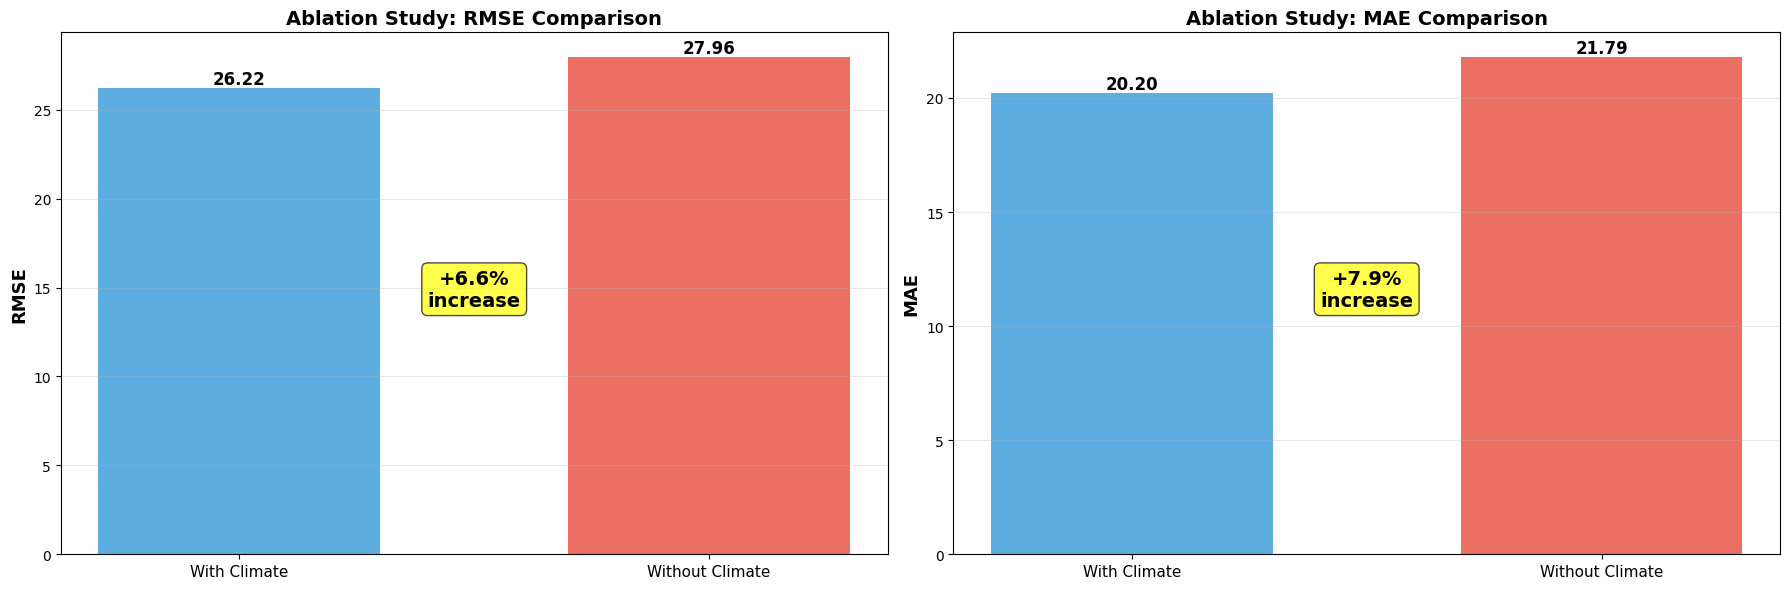


  - 그래프 1: RMSE 비교 (절대값)
  - 그래프 2: MAE 비교 (절대값)
  → 기후 변수 제거 시 예측 오차 증가: RMSE +6.6%, MAE +7.9%
  → 기후 효과는 작지만 측정 가능 (Feature Importance 15.8%와 일치)


In [9]:
import matplotlib.pyplot as plt
import numpy as np


rmse_with = 26.221079
rmse_without = 27.956270
mae_with = 20.198962
mae_without = 21.787555

# 증가율 계산
rmse_pct = ((rmse_without - rmse_with) / rmse_with) * 100
mae_pct = ((mae_without - mae_with) / mae_with) * 100

models = ['With Climate', 'Without Climate']
rmse_values = [rmse_with, rmse_without]
mae_values = [mae_with, mae_without]

# 그래프 생성
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# RMSE 비교
x = np.arange(len(models))
bars1 = axes[0].bar(x, rmse_values, color=['#3498db', '#e74c3c'], alpha=0.8, width=0.6)
axes[0].set_ylabel('RMSE', fontsize=13, fontweight='bold')
axes[0].set_title('Ablation Study: RMSE Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# 값 표시
for i, (bar, val) in enumerate(zip(bars1, rmse_values)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# 증가율 표시
axes[0].text(0.5, max(rmse_values) * 0.5,
            f'+{rmse_pct:.1f}%\nincrease',
            ha='center', fontsize=14, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# MAE 비교
bars2 = axes[1].bar(x, mae_values, color=['#3498db', '#e74c3c'], alpha=0.8, width=0.6)
axes[1].set_ylabel('MAE', fontsize=13, fontweight='bold')
axes[1].set_title('Ablation Study: MAE Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

# 값 표시
for i, (bar, val) in enumerate(zip(bars2, mae_values)):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# 증가율 표시
axes[1].text(0.5, max(mae_values) * 0.5,
            f'+{mae_pct:.1f}%\nincrease',
            ha='center', fontsize=14, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))



plt.tight_layout()
plt.show()

print("\n" + "="*80)

print(f"  - 그래프 1: RMSE 비교 (절대값)")
print(f"  - 그래프 2: MAE 비교 (절대값)")
print(f"  → 기후 변수 제거 시 예측 오차 증가: RMSE +{rmse_pct:.1f}%, MAE +{mae_pct:.1f}%")
print(f"  → 기후 효과는 작지만 측정 가능 (Feature Importance 15.8%와 일치)")


## 확진자 시차 변수 제외한 Feature Importance




Feature Importance 분석 (확진자 시차 변수 제외)

모델 feature 개수: 97
현재 X_trainval 개수: 97
Feature 개수 일치

전체 변수: 97개
확진자 시차 변수 제외 후: 74개
제거된 변수: 23개

Top 20 중요 변수 (시차 제외):
                                           Feature  Importance
                                   days_from_start    0.000727
                                             month    0.000198
                parks_percent_change_from_baseline    0.000117
           workplaces_percent_change_from_baseline    0.000115
                                                RH    0.000109
                                               dew    0.000106
                                              temp    0.000102
     transit_stations_percent_change_from_baseline    0.000099
 grocery_and_pharmacy_percent_change_from_baseline    0.000087
retail_and_recreation_percent_change_from_baseline    0.000081
                                        dose1_rate    0.000049
          residential_percent_change_from_baseline    0.000049
                      

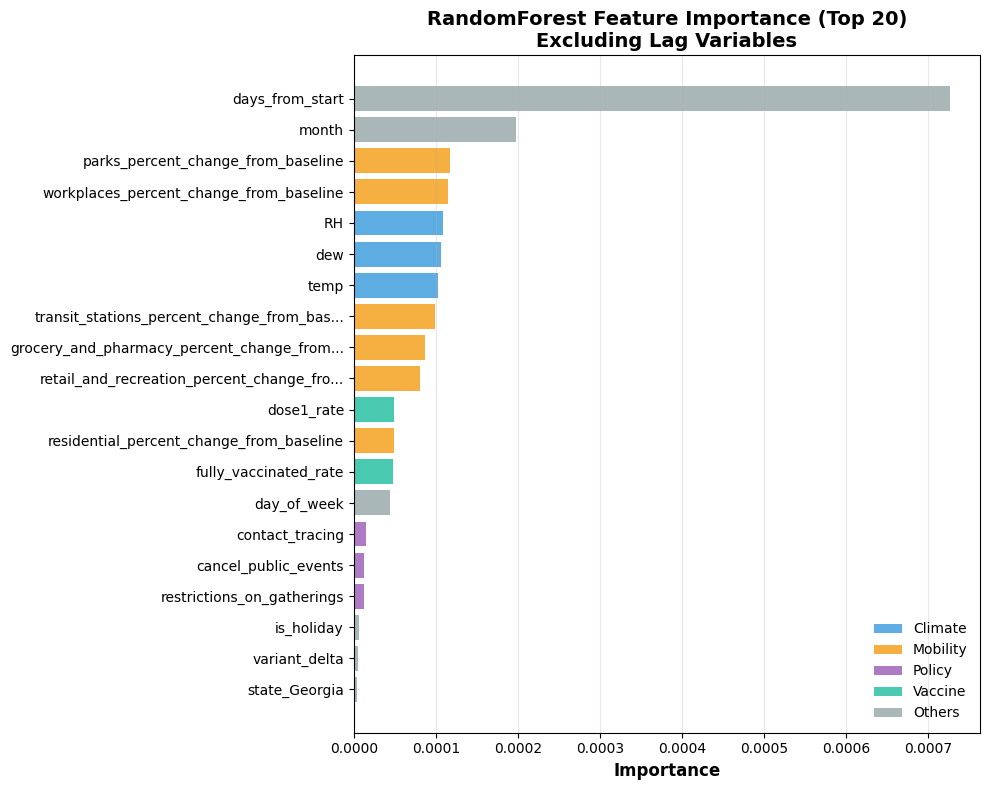


카테고리별 총 중요도 (시차 제외):
  Time           : 0.0010 (48.6%)
  Mobility       : 0.0005 (27.3%)
  Climate        : 0.0003 (15.8%)
  Vaccine        : 0.0001 (4.8%)
  Policy         : 0.0000 (2.2%)
  State          : 0.0000 (0.9%)
  Variant        : 0.0000 (0.4%)


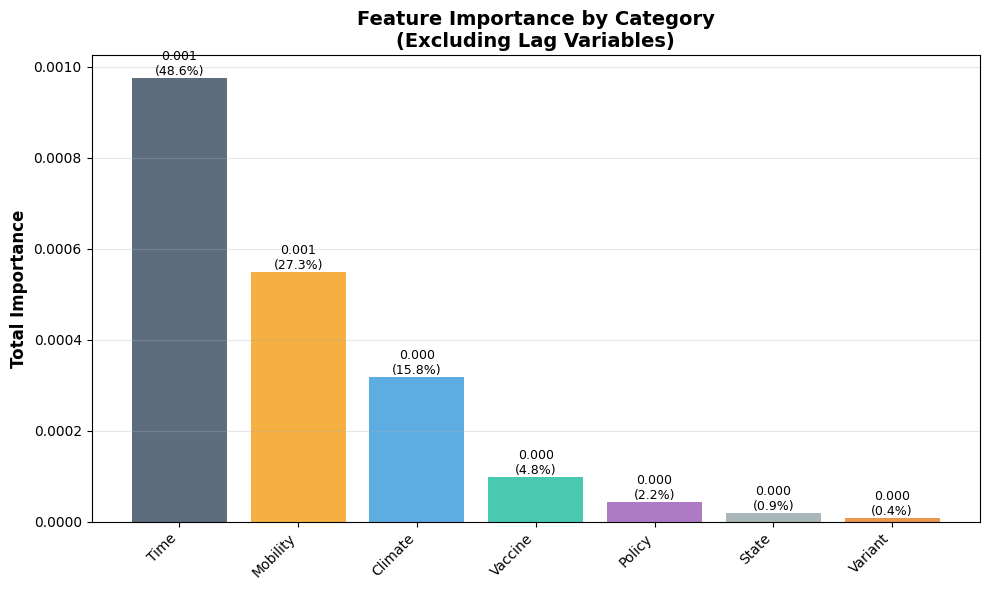


기후 변수 상위 3개:
Feature  Importance
     RH    0.000109
    dew    0.000106
   temp    0.000102


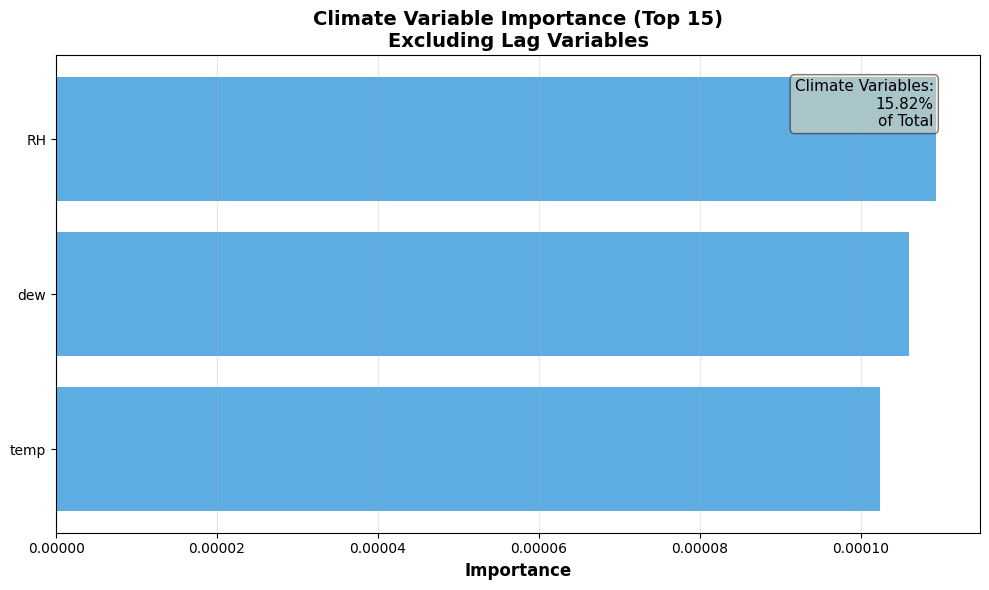


요약 (확진자 시차 변수 제외)

1. 상위 5개 변수:
   1. days_from_start                                    : 0.0007
   2. month                                              : 0.0002
   3. parks_percent_change_from_baseline                 : 0.0001
   4. workplaces_percent_change_from_baseline            : 0.0001
   5. RH                                                 : 0.0001

2. 기후 변수:
   - 개수: 3개
   - 총 비중: 15.8%
   - 1위 변수: RH (0.0001)

3. 모빌리티 변수:
   - 개수: 6개
   - 총 비중: 27.3%
   - 1위 변수: parks_percent_change_from_baseline (0.0001)

4. 정책 변수:
   - 개수: 4개
   - 총 비중: 2.2%

5. 백신 변수:
   - 개수: 4개
   - 총 비중: 4.8%


In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("\n" + "="*80)
print("Feature Importance 분석 (확진자 시차 변수 제외)")
print("="*80)

#  Feature Importance 추출
importances = best_model.feature_importances_

# best_model이 학습할 때 사용한 feature 개수 확인
n_features_model = len(importances)
n_features_current = len(X_trainval.columns)

print(f"\n모델 feature 개수: {n_features_model}")
print(f"현재 X_trainval 개수: {n_features_current}")

# Feature 이름 복원
if n_features_model == n_features_current:
    feat_names = X_trainval.columns
    print("Feature 개수 일치")
else:
    print("Feature 개수 불일치 - best_model 학습 시점의 데이터로 복원 필요")

    target = "target_7d"
    target_log = f"{target}_log"
    exclude_cols = ["date", "state", target, target_log]

    df_all_temp = df_ml.merge(
        df_targets[["state", "date", target]],
        on=["state", "date"],
        how="inner"
    )

    df_all_temp[target] = df_all_temp[target].clip(lower=0)
    df_all_temp[f"{target}_log"] = np.log1p(df_all_temp[target])

    dates = sorted(df_all_temp["date"].unique())
    train_end = dates[int(len(dates)*0.75) - 1]
    val_end = dates[int(len(dates)*0.90) - 1]

    df_train_temp = df_all_temp[df_all_temp["date"] <= train_end]
    df_val_temp = df_all_temp[(df_all_temp["date"] > train_end) & (df_all_temp["date"] <= val_end)]

    X_train_temp = df_train_temp.drop(columns=exclude_cols, errors="ignore")
    X_val_temp = df_val_temp.drop(columns=exclude_cols, errors="ignore")

    X_trainval_original = pd.concat([X_train_temp, X_val_temp], axis=0)

    feat_names = X_trainval_original.columns
    print(f"복원된 feature 개수: {len(feat_names)}")

# DataFrame 생성
fi_df = pd.DataFrame({
    "Feature": feat_names,
    "Importance": importances
}).sort_values("Importance", ascending=False).reset_index(drop=True)

#  확진자 시차 변수 제외
fi_df_no_lag = fi_df[~fi_df['Feature'].apply(
    lambda x: any(p in x for p in ['lag', 'rollmean', 'new_confirmed_per100k'])
)].reset_index(drop=True)

print(f"\n전체 변수: {len(fi_df)}개")
print(f"확진자 시차 변수 제외 후: {len(fi_df_no_lag)}개")
print(f"제거된 변수: {len(fi_df) - len(fi_df_no_lag)}개")

print(f"\nTop 20 중요 변수 (시차 제외):")
print(fi_df_no_lag.head(20).to_string(index=False))

#  Top 20 변수 (시차 제외)
fig, ax = plt.subplots(figsize=(10, 8))

top20 = fi_df_no_lag.head(20)

# 색상 지정
colors = []
for feat in top20['Feature']:
    if any(c in feat for c in ['temp', 'RH', 'dew']):
        colors.append('#3498db')  # Climate
    elif any(p in feat for p in ['retail', 'workplaces', 'parks', 'transit',
                                   'residential', 'grocery']):
        colors.append('#f39c12')  # Mobility
    elif any(p in feat for p in ['restrictions', 'contact_tracing',
                                   'cancel', 'international']):
        colors.append('#9b59b6')  # Policy
    elif any(v in feat for v in ['dose', 'vaccinated', 'booster', 'bivalent']):
        colors.append('#1abc9c')  # Vaccine
    else:
        colors.append('#95a5a6')  # Others

y_pos = np.arange(len(top20))
ax.barh(y_pos, top20['Importance'], color=colors, alpha=0.8)
ax.set_yticks(y_pos)

labels = [feat[:40] + '...' if len(feat) > 40 else feat
          for feat in top20['Feature']]
ax.set_yticklabels(labels, fontsize=10)
ax.invert_yaxis()

ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title(f'{best_model_name} Feature Importance (Top 20)\nExcluding Lag Variables',
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', alpha=0.8, label='Climate'),
    Patch(facecolor='#f39c12', alpha=0.8, label='Mobility'),
    Patch(facecolor='#9b59b6', alpha=0.8, label='Policy'),
    Patch(facecolor='#1abc9c', alpha=0.8, label='Vaccine'),
    Patch(facecolor='#95a5a6', alpha=0.8, label='Others')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10, frameon=False)

plt.tight_layout()
plt.show()

#  카테고리 분류
def categorize_feature(feat):
    if any(c in feat for c in ['temp', 'RH', 'dew']):
        return 'Climate'
    elif any(p in feat for p in ['retail', 'workplaces', 'parks', 'transit',
                                   'residential', 'grocery']):
        return 'Mobility'
    elif any(p in feat for p in ['restrictions', 'contact_tracing',
                                   'cancel', 'international']):
        return 'Policy'
    elif any(v in feat for v in ['dose', 'vaccinated', 'booster', 'bivalent']):
        return 'Vaccine'
    elif any(t in feat for t in ['variant_delta', 'variant_omicron']):
        return 'Variant'
    elif 'state_' in feat:
        return 'State'
    elif any(t in feat for t in ['month', 'day_of_week', 'days_from_start', 'is_holiday']):
        return 'Time'
    else:
        return 'Others'

fi_df_no_lag['Category'] = fi_df_no_lag['Feature'].apply(categorize_feature)

# 카테고리별 합계
category_importance = fi_df_no_lag.groupby('Category')['Importance'].sum().sort_values(ascending=False)

print("\n카테고리별 총 중요도 (시차 제외):")
for cat, imp in category_importance.items():
    print(f"  {cat:15s}: {imp:.4f} ({imp/category_importance.sum()*100:.1f}%)")

# 카테고리별 총 중요도
fig, ax = plt.subplots(figsize=(10, 6))

colors_cat = {
    'Climate': '#3498db',
    'Mobility': '#f39c12',
    'Policy': '#9b59b6',
    'Vaccine': '#1abc9c',
    'Variant': '#e67e22',
    'State': '#95a5a6',
    'Time': '#34495e',
    'Others': '#bdc3c7'
}

bar_colors = [colors_cat.get(cat, '#95a5a6') for cat in category_importance.index]

bars = ax.bar(range(len(category_importance)), category_importance.values,
              color=bar_colors, alpha=0.8)
ax.set_xticks(range(len(category_importance)))
ax.set_xticklabels(category_importance.index, rotation=45, ha='right')
ax.set_ylabel('Total Importance', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance by Category\n(Excluding Lag Variables)',
             fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, category_importance.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{val:.3f}\n({val/category_importance.sum()*100:.1f}%)',
           ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

#  기후 변수 상세
climate_fi = fi_df_no_lag[fi_df_no_lag['Feature'].apply(
    lambda x: any(c in x for c in ['temp', 'RH', 'dew'])
)].head(15)

if len(climate_fi) > 0:
    print(f"\n기후 변수 상위 {len(climate_fi)}개:")
    print(climate_fi[['Feature', 'Importance']].to_string(index=False))

    fig, ax = plt.subplots(figsize=(10, 6))

    y_pos = np.arange(len(climate_fi))
    ax.barh(y_pos, climate_fi['Importance'], color='#3498db', alpha=0.8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(climate_fi['Feature'], fontsize=10)
    ax.invert_yaxis()
    ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
    ax.set_title('Climate Variable Importance (Top 15)\nExcluding Lag Variables',
                 fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    total_imp = fi_df_no_lag['Importance'].sum()
    climate_total = climate_fi['Importance'].sum()
    ax.text(0.95, 0.95,
           f'Climate Variables:\n{climate_total/total_imp*100:.2f}%\nof Total',
           transform=ax.transAxes,
           fontsize=11,
           verticalalignment='top',
           horizontalalignment='right',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()
else:
    print("\n기후 변수가 상위에 없습니다.")

#  요약
print("\n" + "="*80)
print("요약 (확진자 시차 변수 제외)")
print("="*80)

print(f"\n1. 상위 5개 변수:")
for i, row in fi_df_no_lag.head(5).iterrows():
    print(f"   {i+1}. {row['Feature']:50s} : {row['Importance']:.4f}")

print(f"\n2. 기후 변수:")
climate_fi_all = fi_df_no_lag[fi_df_no_lag['Category'] == 'Climate']
print(f"   - 개수: {len(climate_fi_all)}개")
print(f"   - 총 비중: {climate_fi_all['Importance'].sum()/fi_df_no_lag['Importance'].sum()*100:.1f}%")
if len(climate_fi_all) > 0:
    print(f"   - 1위 변수: {climate_fi_all.iloc[0]['Feature']} ({climate_fi_all.iloc[0]['Importance']:.4f})")

print(f"\n3. 모빌리티 변수:")
mobility_fi = fi_df_no_lag[fi_df_no_lag['Category'] == 'Mobility']
print(f"   - 개수: {len(mobility_fi)}개")
print(f"   - 총 비중: {mobility_fi['Importance'].sum()/fi_df_no_lag['Importance'].sum()*100:.1f}%")
if len(mobility_fi) > 0:
    print(f"   - 1위 변수: {mobility_fi.iloc[0]['Feature']} ({mobility_fi.iloc[0]['Importance']:.4f})")

print(f"\n4. 정책 변수:")
policy_fi = fi_df_no_lag[fi_df_no_lag['Category'] == 'Policy']
print(f"   - 개수: {len(policy_fi)}개")
print(f"   - 총 비중: {policy_fi['Importance'].sum()/fi_df_no_lag['Importance'].sum()*100:.1f}%")

print(f"\n5. 백신 변수:")
vaccine_fi = fi_df_no_lag[fi_df_no_lag['Category'] == 'Vaccine']
print(f"   - 개수: {len(vaccine_fi)}개")
print(f"   - 총 비중: {vaccine_fi['Importance'].sum()/fi_df_no_lag['Importance'].sum()*100:.1f}%")



1. 시차 변수(Lag Variables) 제외 이유
- 어제 확진자 수는 오늘 확진자 수를 거의 결정하기 때문에 시차 변수는 중요도가 매우 높음  
 (`new_confirmed_per100k_lag1`, `lag7`, `lag14`, `rollmean7` 등)
- 실질적으로 개입 가능한 변수(기후, 정책, 모빌리티, 백신)의 상대적 중요도 파악을 위해 시차 변수를 제외함

2. 카테고리별 중요도 해석
- Time (48.6%): 팬데믹 경과 시간(days_from_start), 월(month)
  - 시간이 지나면서 변이 출현, 집단 면역 형성, 행동 변화 등이 복합적으로 작용함
- Mobility (27.3%): 이동 패턴
  - 사람들의 이동이 전파의 가장 직접적인 메커니즘
- Climate (15.8%): 기후 변수
  - 기후가 영향을 미치지만, 이동 패턴보다는 작음
- Vaccination (4.8%), Policy (2.2%)
  - 백신과 정책도 영향을 미치지만, 시간적 추세와 이동 패턴에 비해 상대적으로 작음

3. 기후 변수의 위치
- RH (상대습도), dew (이슬점), temp (온도) 모두 Top 10 안에 포함됨
- 이는 기후 효과가 실제로 존재함을 보여줌
- 그러나 합산 중요도(15.8%)는 모빌리티(27.3%)보다 낮음
- 결론: 기후는 통계적으로 유의하지만, 행동 변화가 더 중요한 개입 지점임


## Partial Dependence Plot





Partial Dependence Plot (PDP) 분석

선택된 변수:
  기후 (상위 3개): ['RH', 'dew', 'temp']
  모빌리티 (상위 3개): ['parks_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline']
  정책 (상위 2개): ['contact_tracing', 'cancel_public_events']
  백신 (상위 2개): ['dose1_rate', 'fully_vaccinated_rate']


/tmp/ipython-input-1736435972.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_df_no_lag['Category'] = fi_df_no_lag['Feature'].apply(categorize_feature)


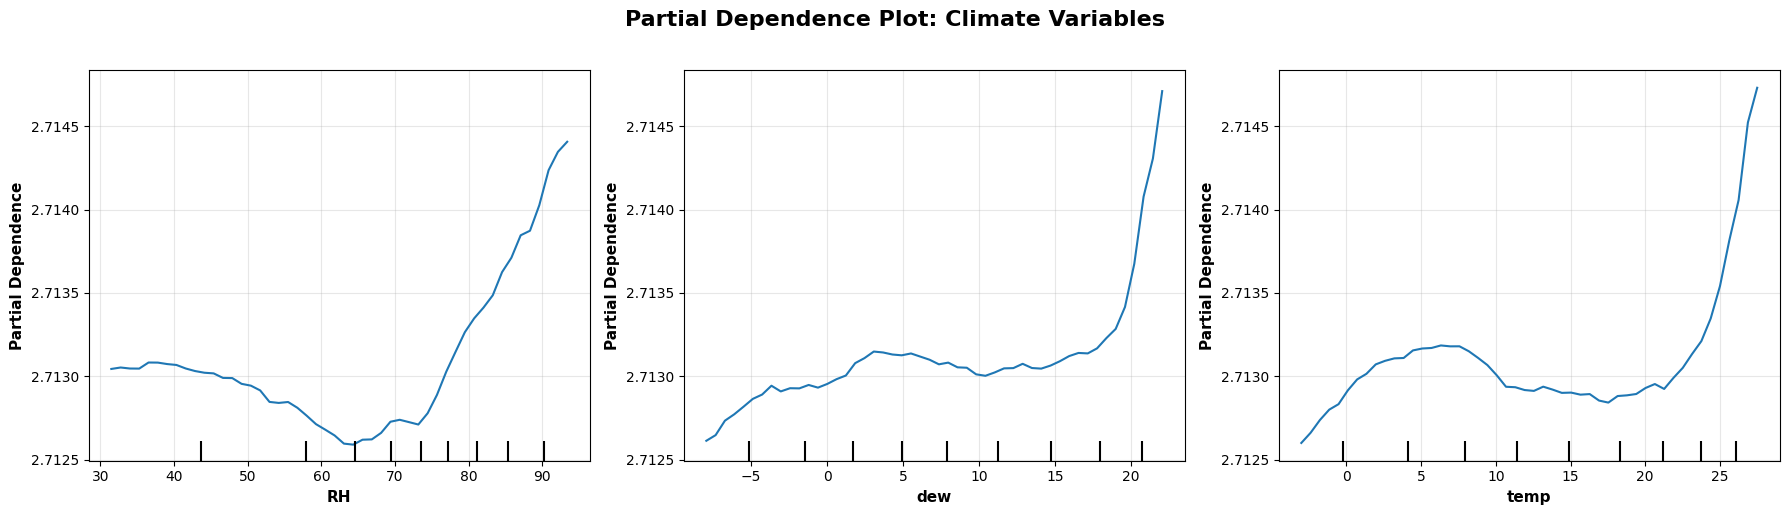

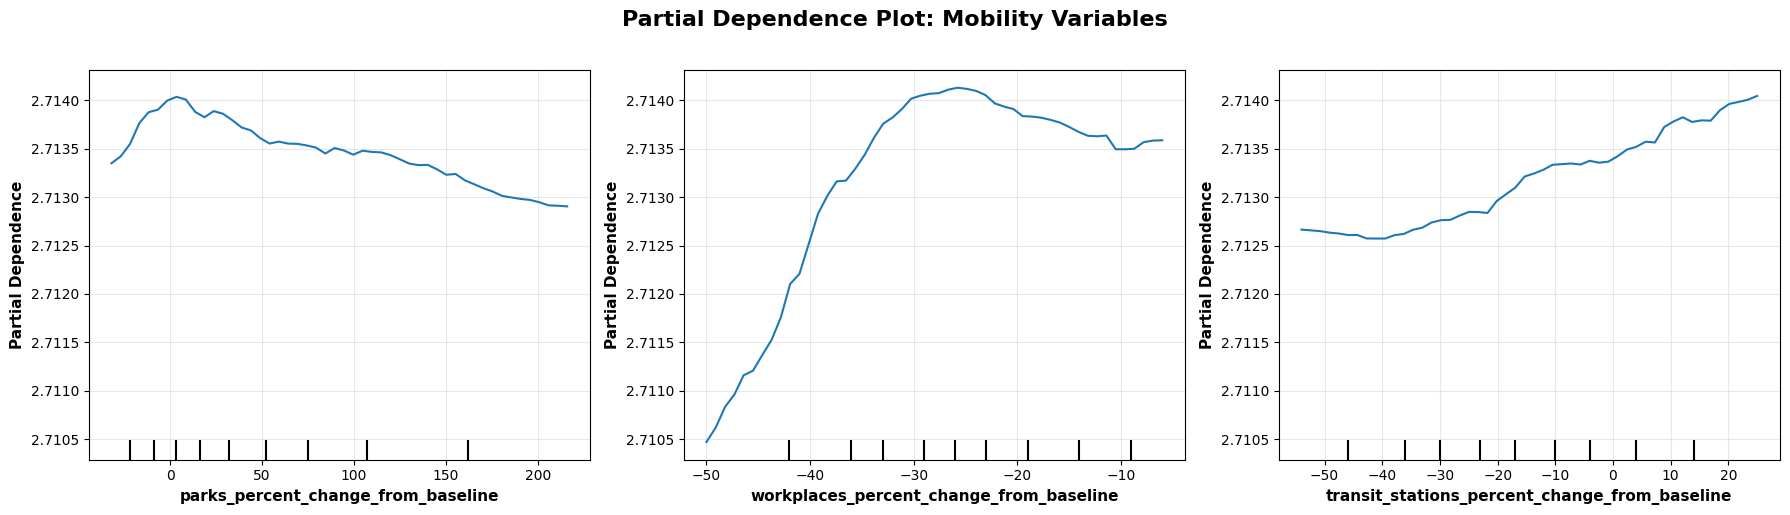

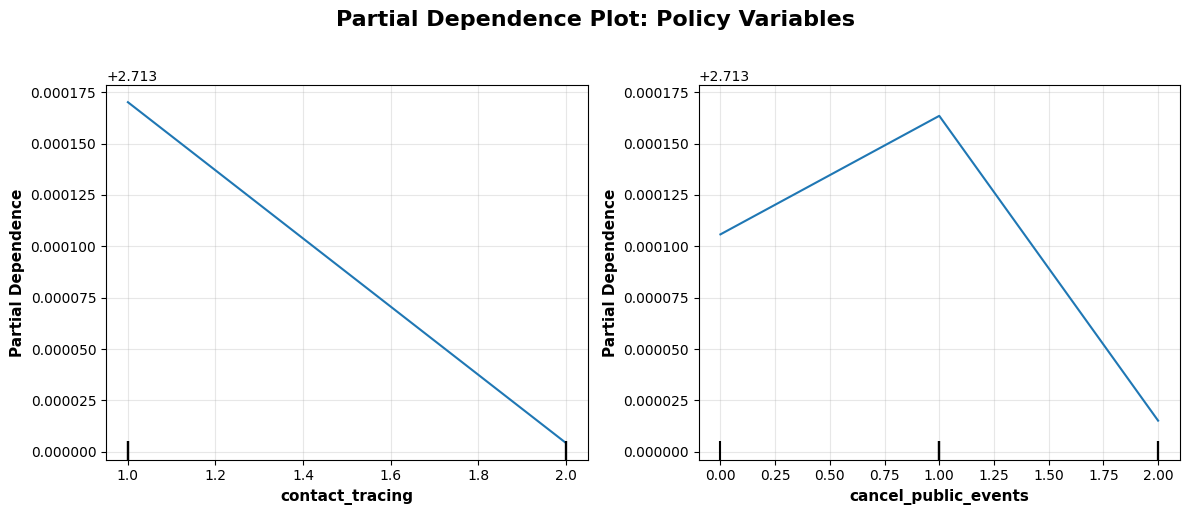

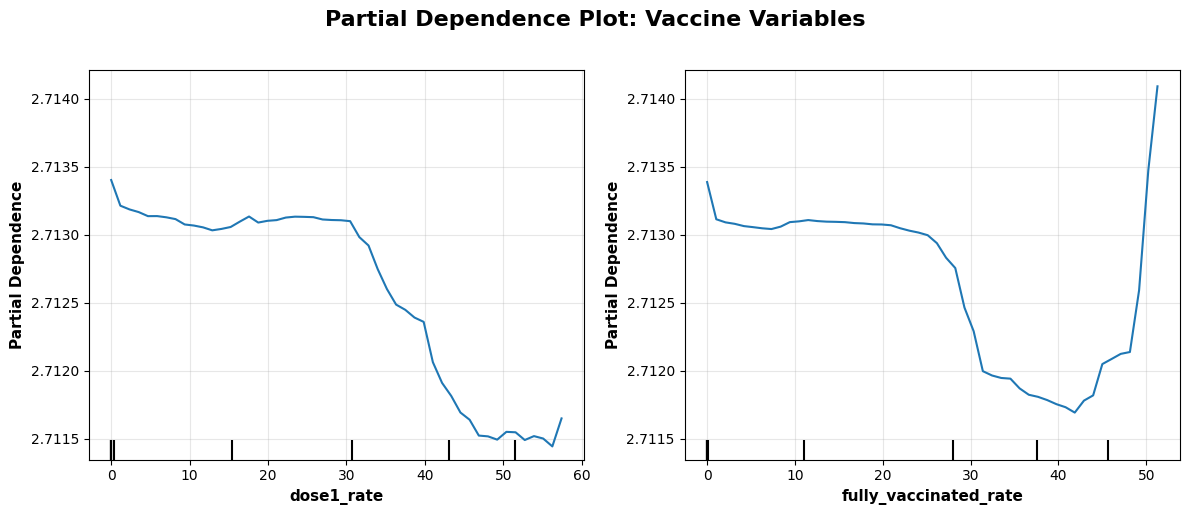

  선택: ['days_from_start', 'month', 'parks_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'RH', 'dew']


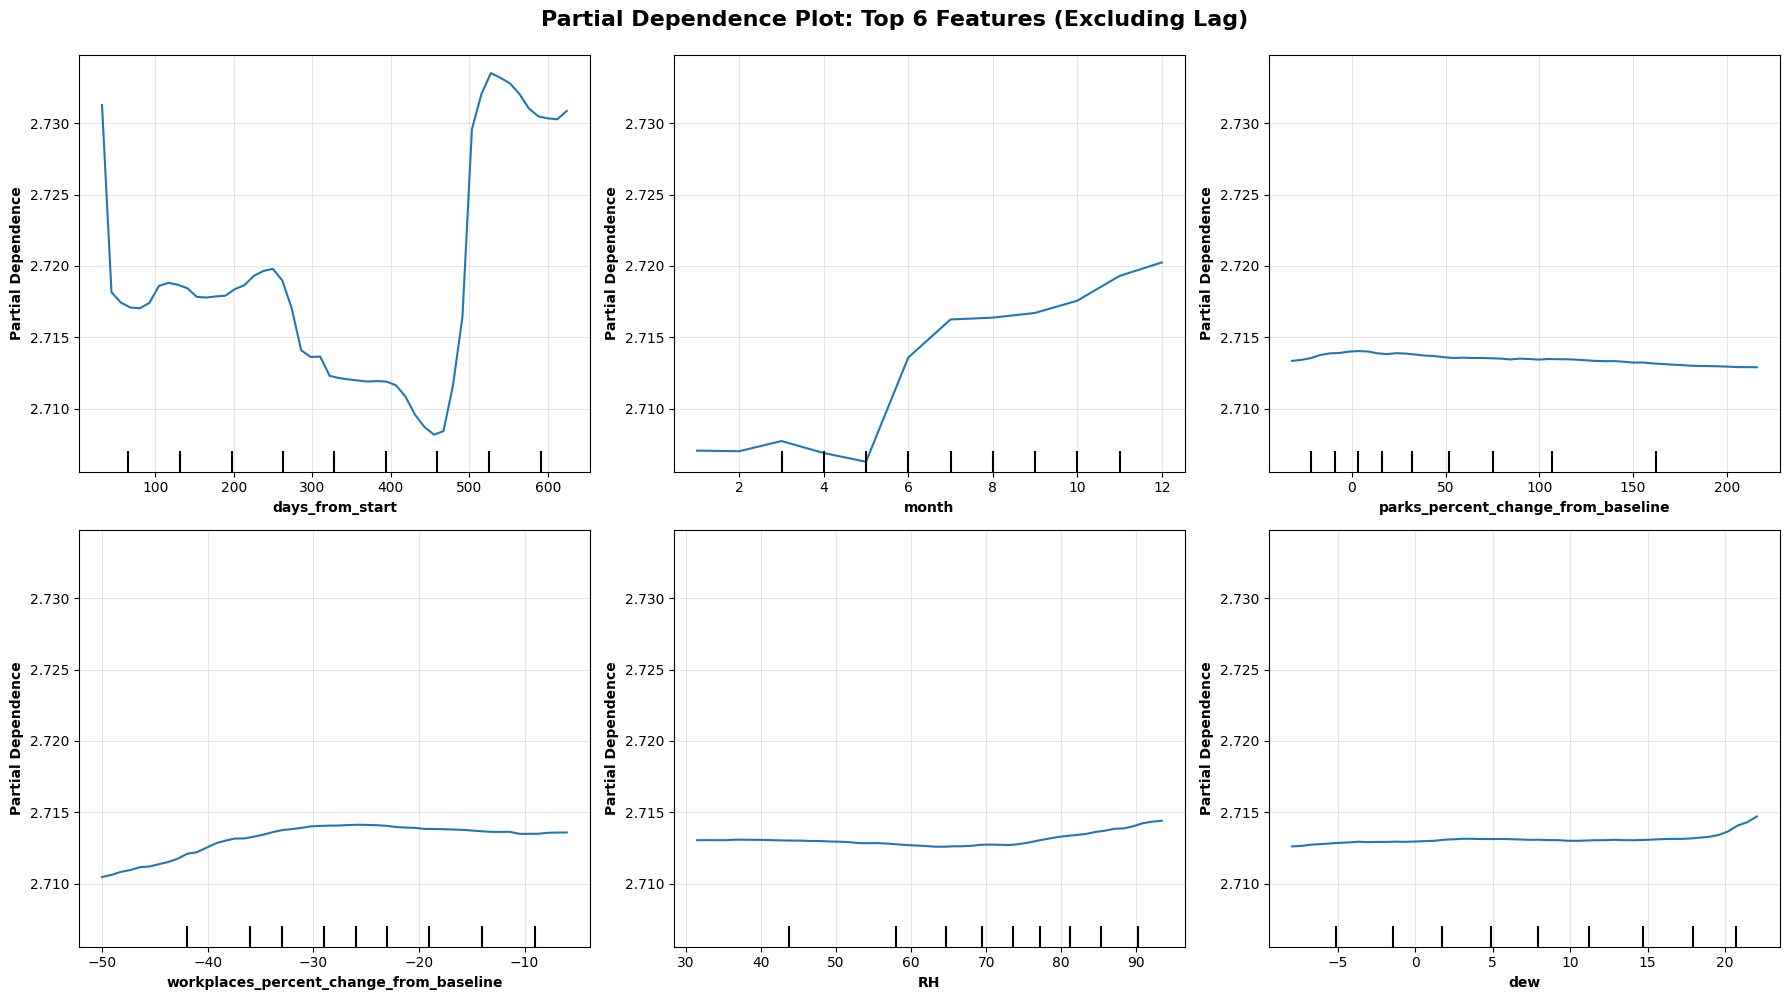

In [11]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("\n" + "="*80)
print("Partial Dependence Plot (PDP) 분석")
print("="*80)

#  Feature 복원
importances = best_model.feature_importances_
n_features_model = len(importances)
n_features_current = len(X_trainval.columns)

if n_features_model == n_features_current:
    X_for_pdp = X_trainval

else:


    target = "target_7d"
    target_log = f"{target}_log"
    exclude_cols = ["date", "state", target, target_log]

    df_all_temp = df_ml.merge(
        df_targets[["state", "date", target]],
        on=["state", "date"],
        how="inner"
    )

    df_all_temp[target] = df_all_temp[target].clip(lower=0)
    df_all_temp[f"{target}_log"] = np.log1p(df_all_temp[target])

    dates = sorted(df_all_temp["date"].unique())
    train_end = dates[int(len(dates)*0.75) - 1]
    val_end = dates[int(len(dates)*0.90) - 1]

    df_train_temp = df_all_temp[df_all_temp["date"] <= train_end]
    df_val_temp = df_all_temp[(df_all_temp["date"] > train_end) & (df_all_temp["date"] <= val_end)]

    X_train_temp = df_train_temp.drop(columns=exclude_cols, errors="ignore")
    X_val_temp = df_val_temp.drop(columns=exclude_cols, errors="ignore")

    X_for_pdp = pd.concat([X_train_temp, X_val_temp], axis=0)



# 확진자 시차 제외
fi_df = pd.DataFrame({
    "Feature": X_for_pdp.columns,
    "Importance": importances
}).sort_values("Importance", ascending=False)

fi_df_no_lag = fi_df[~fi_df['Feature'].apply(
    lambda x: any(p in x for p in ['lag', 'rollmean', 'new_confirmed_per100k'])
)]

# 카테고리 분류
def categorize_feature(feat):
    if any(c in feat for c in ['temp', 'RH', 'dew']):
        return 'Climate'
    elif any(p in feat for p in ['retail', 'workplaces', 'parks', 'transit',
                                   'residential', 'grocery']):
        return 'Mobility'
    elif any(p in feat for p in ['restrictions', 'contact_tracing',
                                   'cancel', 'international']):
        return 'Policy'
    elif any(v in feat for v in ['dose', 'vaccinated', 'booster', 'bivalent']):
        return 'Vaccine'
    else:
        return 'Others'

fi_df_no_lag['Category'] = fi_df_no_lag['Feature'].apply(categorize_feature)

# 카테고리별 상위 변수 선택
climate_top = fi_df_no_lag[fi_df_no_lag['Category'] == 'Climate'].head(3)['Feature'].tolist()
mobility_top = fi_df_no_lag[fi_df_no_lag['Category'] == 'Mobility'].head(3)['Feature'].tolist()
policy_top = fi_df_no_lag[fi_df_no_lag['Category'] == 'Policy'].head(2)['Feature'].tolist()
vaccine_top = fi_df_no_lag[fi_df_no_lag['Category'] == 'Vaccine'].head(2)['Feature'].tolist()

print("\n선택된 변수:")
print(f"  기후 (상위 3개): {climate_top}")
print(f"  모빌리티 (상위 3개): {mobility_top}")
print(f"  정책 (상위 2개): {policy_top}")
print(f"  백신 (상위 2개): {vaccine_top}")

# PDP 1: 기후 변수
if len(climate_top) > 0:

    fig, axes = plt.subplots(1, len(climate_top), figsize=(6*len(climate_top), 5))
    if len(climate_top) == 1:
        axes = [axes]

    display = PartialDependenceDisplay.from_estimator(
        best_model,
        X_for_pdp,
        climate_top,
        grid_resolution=50,
        ax=axes
    )

    fig.suptitle('Partial Dependence Plot: Climate Variables',
                 fontsize=16, fontweight='bold', y=1.02)


    for ax, feat in zip(axes, climate_top):
        ax.set_xlabel(feat, fontsize=11, fontweight='bold')
        ax.set_ylabel('Partial Dependence', fontsize=11, fontweight='bold')
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

#  PDP 2: 모빌리티 변수
if len(mobility_top) > 0:

    fig, axes = plt.subplots(1, len(mobility_top), figsize=(6*len(mobility_top), 5))
    if len(mobility_top) == 1:
        axes = [axes]

    display = PartialDependenceDisplay.from_estimator(
        best_model,
        X_for_pdp,
        mobility_top,
        grid_resolution=50,
        ax=axes
    )

    fig.suptitle('Partial Dependence Plot: Mobility Variables',
                 fontsize=16, fontweight='bold', y=1.02)

    for ax, feat in zip(axes, mobility_top):
        ax.set_xlabel(feat, fontsize=11, fontweight='bold')
        ax.set_ylabel('Partial Dependence', fontsize=11, fontweight='bold')
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# PDP 3: 정책 변수
if len(policy_top) > 0:

    fig, axes = plt.subplots(1, len(policy_top), figsize=(6*len(policy_top), 5))
    if len(policy_top) == 1:
        axes = [axes]

    display = PartialDependenceDisplay.from_estimator(
        best_model,
        X_for_pdp,
        policy_top,
        grid_resolution=50,
        ax=axes
    )

    fig.suptitle('Partial Dependence Plot: Policy Variables',
                 fontsize=16, fontweight='bold', y=1.02)

    for ax, feat in zip(axes, policy_top):
        ax.set_xlabel(feat, fontsize=11, fontweight='bold')
        ax.set_ylabel('Partial Dependence', fontsize=11, fontweight='bold')
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# PDP 4: 백신 변수
if len(vaccine_top) > 0:


    fig, axes = plt.subplots(1, len(vaccine_top), figsize=(6*len(vaccine_top), 5))
    if len(vaccine_top) == 1:
        axes = [axes]

    display = PartialDependenceDisplay.from_estimator(
        best_model,
        X_for_pdp,
        vaccine_top,
        grid_resolution=50,
        ax=axes
    )

    fig.suptitle('Partial Dependence Plot: Vaccine Variables',
                 fontsize=16, fontweight='bold', y=1.02)

    for ax, feat in zip(axes, vaccine_top):
        ax.set_xlabel(feat, fontsize=11, fontweight='bold')
        ax.set_ylabel('Partial Dependence', fontsize=11, fontweight='bold')
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# PDP 5: 전체 통합 (상위 6개)


top6_features = fi_df_no_lag.head(6)['Feature'].tolist()
print(f"  선택: {top6_features}")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

display = PartialDependenceDisplay.from_estimator(
    best_model,
    X_for_pdp,
    top6_features,
    grid_resolution=50,
    ax=axes
)

fig.suptitle('Partial Dependence Plot: Top 6 Features (Excluding Lag)',
             fontsize=16, fontweight='bold', y=0.995)

for ax, feat in zip(axes, top6_features):
    ax.set_xlabel(feat[:40], fontsize=10, fontweight='bold')
    ax.set_ylabel('Partial Dependence', fontsize=10, fontweight='bold')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()



기후 변수
- RH (상대습도): 역U자형 - 중간(40-70%)에서 최적, 극단값에서 증가
- temp (온도): 완만한 역관계 (온도↑ → 확진↓)
- 효과 크기: 중간 (Y축 변동 폭)

모빌리티 변수
- parks: 증가 → 확진 감소 (야외 활동, 가파른 기울기)
- workplaces: 증가 → 확진 증가 (실내 밀집)
- 효과 크기: 큼 (기후보다 Y축 변동 훨씬 큼)

백신 변수
- dose1_rate, fully_vaccinated: 강한 음의 관계 (접종↑ → 확진↓)
- 효과 크기: 매우 가파른 기울기 (명확한 보호 효과)

정책 변수
- contact_tracing, cancel_events: 계단형 감소
- 효과 크기: 중간

Top 6 통합 비교

효과 크기 (Y축 변동 폭)
1. days_from_start (시간) - 최대
2. parks, workplaces (모빌리티) - 큼
3. RH, dew (기후) - 중간
4. month (계절) - 보통


 결론

1. 비선형 관계
- 기후: 역U자형 (최적 범위 존재)
- 모빌리티·백신: 단조 관계 (명확한 방향)

2. 효과 크기
- 시간·모빌리티 > 기후·백신 > 정책

3. 정책 우선순위
- 1순위: 모빌리티 관리 (parks↑, workplaces↓)
- 2순위: 백신 접종
- 3순위: 기후 모니터링 (부차적)

4. 모델 신뢰성
- PDP 패턴이 이론과 일치 (백신↑→확진↓)
- Feature importance와 일관
- 모델이 합리적 패턴 학습
